In [179]:
# This notebook will be for Classification testing (Supervised Learning)
# Decision Tree, SGD Classifier/SVM - Logistic Regression
# Importing Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, confusion_matrix
from sklearn.metrics import classification_report, roc_curve, precision_score, recall_score, f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
pd.options.mode.copy_on_write = True

## Prepping Data for Model Training

In [161]:
# # importing dataset
# old way
from dotenv import load_dotenv

load_dotenv()

dataset_path = os.getenv('CLEANED_DATA_PATH')

df_cleaned = pd.read_csv(dataset_path)

In [162]:
# importing dataset
# df_cleaned = pd.read_parquet('data/application_cleaned.parquet', engine = 'pyarrow')

^ for some reason the OCCUPATION_TYPE column was behaving weirdly when I used this, maybe I did not run all the cells in the main notebook before exporting but idk

In [163]:
df_cleaned.shape

(307507, 56)

In [164]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307507 entries, 0 to 307506
Data columns (total 56 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   307507 non-null  int64  
 1   TARGET                       307507 non-null  int64  
 2   NAME_CONTRACT_TYPE           307507 non-null  object 
 3   CODE_GENDER                  307507 non-null  object 
 4   FLAG_OWN_CAR                 307507 non-null  object 
 5   FLAG_OWN_REALTY              307507 non-null  object 
 6   CNT_CHILDREN                 307507 non-null  int64  
 7   AMT_INCOME_TOTAL             307507 non-null  float64
 8   AMT_CREDIT                   307507 non-null  float64
 9   AMT_ANNUITY                  307495 non-null  float64
 10  AMT_GOODS_PRICE              307229 non-null  float64
 11  NAME_TYPE_SUITE              306215 non-null  object 
 12  NAME_INCOME_TYPE             307507 non-null  object 
 13 

In [165]:
# dropping continuous columns in favor of binned columns
df_cleaned.drop(labels=['YEARS_EMPLOYED', 'AMT_CREDIT', 'AMT_INCOME_TOTAL'], axis=1, inplace=True)

In [166]:
# removing ID column
df_cleaned.drop(labels='SK_ID_CURR', axis=1, inplace=True)

In [167]:
# goodbye new mothers
df_cleaned = df_cleaned[df_cleaned['NAME_INCOME_TYPE'] != 'Maternity leave']

In [168]:
# determing the imbalance ratio
imb_ratio = df_cleaned[df_cleaned['TARGET'] == 0]['TARGET'].count() / df_cleaned[df_cleaned['TARGET'] == 1]['TARGET'].count()
print(imb_ratio)

11.387785521492164


In [169]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 307502 entries, 0 to 307506
Data columns (total 52 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   TARGET                       307502 non-null  int64  
 1   NAME_CONTRACT_TYPE           307502 non-null  object 
 2   CODE_GENDER                  307502 non-null  object 
 3   FLAG_OWN_CAR                 307502 non-null  object 
 4   FLAG_OWN_REALTY              307502 non-null  object 
 5   CNT_CHILDREN                 307502 non-null  int64  
 6   AMT_ANNUITY                  307490 non-null  float64
 7   AMT_GOODS_PRICE              307224 non-null  float64
 8   NAME_TYPE_SUITE              306210 non-null  object 
 9   NAME_INCOME_TYPE             307502 non-null  object 
 10  NAME_EDUCATION_TYPE          307502 non-null  object 
 11  NAME_FAMILY_STATUS           307502 non-null  object 
 12  NAME_HOUSING_TYPE            307502 non-null  object 
 13  REGI

In [170]:
# creating list of categorical columns
categorical_cols = df_cleaned.select_dtypes(include=['object']).columns.tolist()
categorical_cols

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'AMT_INCOME_RANGE',
 'AMT_CREDIT_RANGE',
 'AGE_GROUP',
 'EMPLOYMENT_YEAR']

In [171]:
# creating list of numerical columns
numerical_cols = df_cleaned.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('TARGET')
numerical_cols

['CNT_CHILDREN',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'FLAG_DOCUMENT_3',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'AGE']

In [172]:
# viewing the number of null values in each column
null_counts = df_cleaned.isnull().sum()
print(null_counts)

TARGET                             0
NAME_CONTRACT_TYPE                 0
CODE_GENDER                        0
FLAG_OWN_CAR                       0
FLAG_OWN_REALTY                    0
CNT_CHILDREN                       0
AMT_ANNUITY                       12
AMT_GOODS_PRICE                  278
NAME_TYPE_SUITE                 1292
NAME_INCOME_TYPE                   0
NAME_EDUCATION_TYPE                0
NAME_FAMILY_STATUS                 0
NAME_HOUSING_TYPE                  0
REGION_POPULATION_RELATIVE         0
DAYS_BIRTH                         0
DAYS_EMPLOYED                      0
DAYS_REGISTRATION                  0
DAYS_ID_PUBLISH                    0
FLAG_EMP_PHONE                     0
FLAG_WORK_PHONE                    0
OCCUPATION_TYPE                    0
CNT_FAM_MEMBERS                    2
REGION_RATING_CLIENT               0
REGION_RATING_CLIENT_W_CITY        0
WEEKDAY_APPR_PROCESS_START         0
HOUR_APPR_PROCESS_START            0
REG_REGION_NOT_LIVE_REGION         0
R

In [173]:
# Separate features and target
X = df_cleaned.drop('TARGET', axis=1)
if 'SK_ID_CURR' in X.columns:
    X = X.drop('SK_ID_CURR', axis=1)  # Remove ID column if present
y = df_cleaned['TARGET']

In [ ]:
# function for scaling and imputing X_train

def scale_impute_train(X_train):

    # Feature scaling
    print(f'Applying feature scaling for X_train...')

    # Scale numerical features
    scaler = RobustScaler()
    X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols]);
    print(f'Scaled {len(numerical_cols)} numerical columns for X_train')


    #Imputing missing values
    print(f'Imputing missing values for X_train...')
    imputer = ColumnTransformer(transformers=
                            [('numimp', SimpleImputer(strategy='median', add_indicator=True), numerical_cols),
                            ('catimp', SimpleImputer(strategy='most_frequent', add_indicator=True), categorical_cols)], 
                            remainder="passthrough").set_output(transform='pandas')
    # num_imputer = SimpleImputer(strategy='mean', add_indicator=True)
    X_train = imputer.fit_transform(X_train)
    print(f'Imputed numerical columns & categorical columns for X_train')

    # Verify no missing values remain
    missing_after = X_train.isnull().sum().sum()
    print(f'Missing values after imputation: {missing_after} for X_train')


    categorical_cols_imp = X_train.select_dtypes(include=['object']).columns.tolist()
    print(f'Number of Categorical Columns: {len(categorical_cols_imp)}')

    # finding cat columns that are binary
    binary_cat_col_imp = []
    for col in categorical_cols_imp:
        if X_train[col].nunique() == 2:
            binary_cat_col_imp.append(col)
    print(f'Number of Binary Categorical Columns: {len(binary_cat_col_imp)}')

    # removing binary columns from list before OHE
    for col in binary_cat_col_imp:
        categorical_cols_imp.remove(col)
    print(f'Number of Multiclass Categorical Columns: {len(categorical_cols_imp)}')
            

    # label encoding binary categorical variables, converting to 0 or 1
    le = LabelEncoder()
    for col in binary_cat_col_imp:
        X_train[col] = le.fit_transform(X_train[col])

    # onehot encoding multiclass category variables
    ct = ColumnTransformer(transformers=[('ohe', OneHotEncoder(sparse_output=False), categorical_cols_imp)], 
                        remainder="passthrough").set_output(transform='pandas')

    X_train = ct.fit_transform(X_train)

    return X_train, imputer, scaler
    

In [ ]:
# function for scaling and imputing X_test
def scale_impute_test(X_test, imputer, scaler):
    # Applying preprocessing to X_test

    # Feature scaling
    print(f'Applying feature scaling for X_test...')

    # Scale numerical features
    X_test[numerical_cols] = scaler.transform(X_test[numerical_cols]); #transforming the test data using the scaler that was fit to training data
    print(f'Scaled {len(numerical_cols)} numerical columns for X_test')

    #Imputing missing values
    print(f'Imputing missing values for X_test...')
    X_test = imputer.transform(X_test)
    print(f'Imputed numerical columns & categorical columns for X_test')

    # Verify no missing values remain
    missing_after = X_test.isnull().sum().sum()
    print(f'Missing values after imputation: {missing_after} for X_test')

    categorical_cols_imp = X_test.select_dtypes(include=['object']).columns.tolist()
    print(f'Number of Categorical Columns: {len(categorical_cols_imp)}')

    # finding cat columns that are binary
    binary_cat_col_imp = []
    for col in categorical_cols_imp:
        if X_test[col].nunique() == 2:
            binary_cat_col_imp.append(col)
    print(f'Number of Binary Categorical Columns: {len(binary_cat_col_imp)}')

    # removing binary columns from list before OHE
    for col in binary_cat_col_imp:
        categorical_cols_imp.remove(col)
    print(f'Number of Multiclass Categorical Columns: {len(categorical_cols_imp)}')
            

    # label encoding binary categorical variables
    le = LabelEncoder()
    for col in binary_cat_col_imp:
        X_test[col] = le.fit_transform(X_test[col])

    # onehot encoding multiclass category variables and 
    ct = ColumnTransformer(transformers=[('ohe', OneHotEncoder(sparse_output=False), categorical_cols_imp)], 
                        remainder="passthrough").set_output(transform='pandas')
                        
    X_test = ct.fit_transform(X_test)

    return X_test

In [176]:
# function for ensuring both sets have the same columns
def check_columns(X_train_transformed, X_test_transformed):
    
    # dropping missingindicator columns that are not present in both datasets
    train_col_list = X_train_transformed.columns.to_list()

    test_col_list = X_test_transformed.columns.to_list()

    # finding columns that are only in train
    diff_1 = [item for item in train_col_list if item not in test_col_list]

    if len(diff_1) > 0:
        print(f'Removing...{diff_1} from X_train')
        X_train_transformed.drop(labels=diff_1, axis=1, inplace=True)

    # finding columns that are only in test
    diff_2 = [item for item in test_col_list if item not in train_col_list]

    if len(diff_2) > 0:
        print(f'Removing...{diff_2} from X_test')
        X_test_transformed.drop(labels=diff_2, axis=1, inplace=True)

## Stratified K-Folds Cross Validation

In [178]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)

# model = XGBClassifier(min_child_weight=10, 
#                       max_depth=1000, 
#                       subsample=0.2, 
#                       colsample_bytree=0.5, 
#                       learning_rate=0.3, 
#                       num_boost_round=300,
#                       scale_pos_weight=9)

model = LogisticRegression(max_iter=100, 
                           class_weight={1:6},
                           solver='liblinear', 
                           penalty='l2', 
                           C=0.01)
# model = RandomForestClassifier()

results = []

for train_index, test_index in skf.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # scaling the train and test data
    X_train_transformed, imputer, scaler = scale_impute_train(X_train)
    X_test_transformed = scale_impute_test(X_test, imputer, scaler)

    # ensuring both train and test sets have the same columns and removing differences
    check_columns(X_train_transformed, X_test_transformed)

    # fitting model
    model.fit(X_train_transformed, y_train)

    # Make predictions
    y_pred_proba = model.predict_proba(X_test_transformed)[:, 1]
    y_pred = model.predict(X_test_transformed)

    # Calculate metrics
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)

    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall_curve, precision_curve)

    # Create classification report
    report = classification_report(y_test, y_pred)

    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    
    result = {
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'mcc': mcc,
        'classification_report': report
    }

    print(f"  Precision: {result['precision']:.4f}")
    print(f"  Recall: {result['recall']:.4f}")
    print(f"  F1 Score: {result['f1_score']:.4f}")
    print(f"  ROC AUC: {result['roc_auc']:.4f}")
    print(f"  PR AUC: {result['pr_auc']:.4f}")
    print(f"  MCC: {result['mcc']:.4f}")


    results.append(result)

# Create results summary
results_df = pd.DataFrame(results)
results_df = results_df.drop('classification_report', axis=1)
# results_df.to_csv('ml_results/model_comparison.csv', index=False)

# Print average of metrics
print("\nPrinting the average of the CV folds...\n")

print(f"  Mean Precision: {results_df['precision'].mean():.4f}")
print(f"  Mean Recall: {results_df['recall'].mean():.4f}")
print(f"  Mean F1 Score: {results_df['f1_score'].mean():.4f}")
print(f"  Mean ROC AUC: {results_df['roc_auc'].mean():.4f}")
print(f"  Mean PR AUC: {results_df['pr_auc'].mean():.4f}")
print(f"  Mean MCC: {results_df['mcc'].mean():.4f}")

Applying feature scaling for X_train...
Scaled 35 numerical columns for X_train


Imputing missing values for X_train...
Imputed numerical columns & categorical columns for X_train


Missing values after imputation: 0 for X_train


Number of Categorical Columns: 17
Number of Binary Categorical Columns: 5
Number of Multiclass Categorical Columns: 12
Applying feature scaling for X_test...
Scaled 35 numerical columns for X_test


Imputing missing values for X_test...
Imputed numerical columns & categorical columns for X_test


Missing values after imputation: 0 for X_test


Number of Categorical Columns: 17
Number of Binary Categorical Columns: 5
Number of Multiclass Categorical Columns: 12
Removing...['ohe__catimp__NAME_FAMILY_STATUS_Unknown', 'ohe__catimp__AGE_GROUP_0-20'] from X_train
[[49520  7016]
 [ 2906  2059]]
  Precision: 0.2269
  Recall: 0.4147
  F1 Score: 0.2933
  ROC AUC: 0.7449
  PR AUC: 0.2247
  MCC: 0.2232
Applying feature scaling for X_train...
Scaled 35 numerical columns 

## Hyperparameter Optimization

In [116]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69, stratify=y)

# scaling the train and test data
X_train_transformed, imputer, scaler = scale_impute_train(X_train)
X_test_transformed = scale_impute_test(X_test, imputer, scaler)

# ensuring both train and test sets have the same columns
check_columns(X_train_transformed, X_test_transformed)

Applying feature scaling for X_train...
Scaled 31 numerical columns for X_train


Imputing missing values for X_train...
Imputed numerical columns & categorical columns for X_train


Missing values after imputation: 0 for X_train


Number of Categorical Columns: 14
Number of Binary Categorical Columns: 6
Number of Multiclass Categorical Columns: 8
Applying feature scaling for X_test...
Scaled 31 numerical columns for X_test


Imputing missing values for X_test...
Imputed numerical columns & categorical columns for X_test


Missing values after imputation: 0 for X_test


Number of Categorical Columns: 14
Number of Binary Categorical Columns: 6
Number of Multiclass Categorical Columns: 8
Removing...['ohe__catimp__NAME_FAMILY_STATUS_Unknown'] from X_train


In [154]:
# using Optuna
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

def objective(trial):
    classifier_name = trial.suggest_categorical("classifier", ["RandomForest", "DecisionTree"])

    if classifier_name == 'RandomForest':
        rf_max_depth = trial.suggest_int("rf_max_depth", 2, 100, log=True)
        rf_n_estimators = trial.suggest_int("rf_n_estimators", 100, 1000, log=True)
        rf_min_samples_split = trial.suggest_int("rf_min_samples_split", 2, 30, log=True)
        rf_min_samples_leaf = trial.suggest_int("rf_min_samples_leaf", 1, 100, log=True)
        rf_min_weight_fraction_leaf = trial.suggest_float("rf_min_weight_fraction_leaf", 0.1, 0.5, log=True)

        classifier_obj = RandomForestClassifier(max_depth=rf_max_depth,
                                                n_estimators=rf_n_estimators,
                                                min_samples_split=rf_min_samples_split,
                                                min_samples_leaf=rf_min_samples_leaf,
                                                min_weight_fraction_leaf=rf_min_weight_fraction_leaf,
                                                class_weight= {1: 2},
                                                random_state=69)
    else:
        dt_max_depth = trial.suggest_int("rf_max_depth", 2, 100, log=True)
        dt_min_samples_split = trial.suggest_int("rf_min_samples_split", 2, 30, log=True)
        dt_min_samples_leaf = trial.suggest_int("rf_min_samples_leaf", 1, 100, log=True)
        dt_min_weight_fraction_leaf = trial.suggest_float("rf_min_weight_fraction_leaf", 0.1, 0.5, log=True)

        classifier_obj = DecisionTreeClassifier(max_depth=dt_max_depth,
                                                min_samples_split=dt_min_samples_split,
                                                min_samples_leaf=dt_min_samples_leaf,
                                                min_weight_fraction_leaf=dt_min_weight_fraction_leaf,
                                                random_state=69)
    scorer = make_scorer(f1_score)
    score = cross_val_score(classifier_obj, X_train_transformed, y_train, n_jobs=-1, cv=5, scoring=scorer)
    f1 = score.mean()
    return f1

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
print(study.best_trial)

                                                
        

[I 2025-04-22 10:45:00,349] A new study created in memory with name: no-name-6373e219-05e9-4993-97d0-a3cb561aa19e
[I 2025-04-22 10:45:06,709] Trial 0 finished with value: 0.0 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 64, 'rf_n_estimators': 101, 'rf_min_samples_split': 7, 'rf_min_samples_leaf': 52, 'rf_min_weight_fraction_leaf': 0.32736385130057616}. Best is trial 0 with value: 0.0.
[I 2025-04-22 10:45:11,895] Trial 1 finished with value: 0.0 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 93, 'rf_n_estimators': 147, 'rf_min_samples_split': 5, 'rf_min_samples_leaf': 9, 'rf_min_weight_fraction_leaf': 0.47602219355221936}. Best is trial 0 with value: 0.0.
[I 2025-04-22 10:45:13,823] Trial 2 finished with value: 0.0 and parameters: {'classifier': 'DecisionTree', 'rf_max_depth': 14, 'rf_min_samples_split': 2, 'rf_min_samples_leaf': 4, 'rf_min_weight_fraction_leaf': 0.43646832476438324}. Best is trial 0 with value: 0.0.
[I 2025-04-22 10:45:15,986] Trial 3 

FrozenTrial(number=0, state=1, values=[0.0], datetime_start=datetime.datetime(2025, 4, 22, 10, 45, 0, 351140), datetime_complete=datetime.datetime(2025, 4, 22, 10, 45, 6, 708336), params={'classifier': 'RandomForest', 'rf_max_depth': 64, 'rf_n_estimators': 101, 'rf_min_samples_split': 7, 'rf_min_samples_leaf': 52, 'rf_min_weight_fraction_leaf': 0.32736385130057616}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'classifier': CategoricalDistribution(choices=('RandomForest', 'DecisionTree')), 'rf_max_depth': IntDistribution(high=100, log=True, low=2, step=1), 'rf_n_estimators': IntDistribution(high=1000, log=True, low=100, step=1), 'rf_min_samples_split': IntDistribution(high=30, log=True, low=2, step=1), 'rf_min_samples_leaf': IntDistribution(high=100, log=True, low=1, step=1), 'rf_min_weight_fraction_leaf': FloatDistribution(high=0.5, log=True, low=0.1, step=None)}, trial_id=0, value=None)


In [153]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer

# parameters to optimize
param_dist = {
    'class_weight': [{1: 2}, {1: 3}, {1: 4}, {1: 5}, {1: 6}, {1: 7}, {1: 8}, {1: 9}, {1: 10}]
}

# score function to optimize
scorer = make_scorer(f1_score)

model = RandomForestClassifier()

rscv = RandomizedSearchCV(model, param_distributions=param_dist, scoring=scorer, random_state=69)

search = rscv.fit(X_train_transformed, y_train)

print(search.best_params_)

{'class_weight': {1: 2}}


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer

# parameters to optimize
param_dist = {
    'min_child_weight': [1, 10, 100, 1000],
    'max_depth': [0, 10, 100, 1000],
    'subsample': np.arange(0.1, 0.9, 0.1),
    'colsample_bytree': np.arange(0.2, 0.9, 0.1),
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
    'num_boost_round': np.arange(100, 1000, 100),
    'scale_pos_weight': np.arange(1, 12, 0.5)
}

# score function to optimize
scorer = make_scorer(f1_score)

xgb = XGBClassifier()

rscv = RandomizedSearchCV(xgb, param_distributions=param_dist, scoring=scorer, random_state=69)

search = rscv.fit(X_train_transformed, y_train)

print(search.best_params_)

{'min_child_weight': 10, 'max_depth': 1000}


In [97]:
# parameters to optimize
param_dist = {
    'class_weight': [{1: 2}, {1: 3}, {1: 4}, {1: 5}, {1: 6}, {1: 7}, {1: 8}, {1: 9}, {1: 10}],
    'max_iter': np.arange(100, 1000, 100)
}

# score function to optimize
scorer = make_scorer(f1_score)

model = LogisticRegression()

rscv = RandomizedSearchCV(model, param_distributions=param_dist, scoring=scorer, random_state=69)

search = rscv.fit(X_train_transformed, y_train)

print(search.best_params_)

{'max_iter': np.int64(100), 'class_weight': {1: 6}}


In [101]:
# parameters to optimize
param_dist = {
        'solver': ['newton-cg', 'lbfgs', 'liblinear'],
        'penalty': ['l2'],
        'C': [100, 10, 1.0, 0.1, 0.01],
}

# score function to optimize
scorer = make_scorer(f1_score)

model = LogisticRegression(class_weight={1:6}, max_iter=100)

rscv = RandomizedSearchCV(model, param_distributions=param_dist, scoring=scorer, random_state=69)

search = rscv.fit(X_train_transformed, y_train)

print(search.best_params_)

{'solver': 'liblinear', 'penalty': 'l2', 'C': 0.01}


In [ ]:
# parameters to optimize
param_dist = {
    'class_weight': [{1: 2}, {1: 3}, {1: 4}, {1: 5}, {1: 6}, {1: 7}, {1: 8}, {1: 9}, {1: 10}],
    'max_iter': np.arange(100, 1000, 100),
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'penalty': ['l2'],
    'C': [100, 10, 1.0, 0.1, 0.01],
}

# score function to optimize
scorer = make_scorer(f1_score)

model = LogisticRegression()

rscv = RandomizedSearchCV(model, param_distributions=param_dist, scoring=scorer, random_state=69)

search = rscv.fit(X_train_transformed, y_train)

print(search.best_params_)

## Splitting, Scaling, Imputing, and OHE

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69, stratify=y)

In [19]:
null_counts = X_train.isnull().sum()
print(null_counts)

NAME_CONTRACT_TYPE                 0
CODE_GENDER                        0
FLAG_OWN_CAR                       0
FLAG_OWN_REALTY                    0
CNT_CHILDREN                       0
AMT_INCOME_TOTAL                   0
AMT_CREDIT                         0
AMT_ANNUITY                       11
NAME_TYPE_SUITE                 1014
NAME_INCOME_TYPE                   0
NAME_EDUCATION_TYPE                0
NAME_FAMILY_STATUS                 0
NAME_HOUSING_TYPE                  0
REGION_POPULATION_RELATIVE         0
DAYS_BIRTH                         0
DAYS_EMPLOYED                      0
DAYS_REGISTRATION                  0
DAYS_ID_PUBLISH                    0
FLAG_EMP_PHONE                     0
FLAG_WORK_PHONE                    0
OCCUPATION_TYPE                32606
CNT_FAM_MEMBERS                    2
REGION_RATING_CLIENT_W_CITY        0
WEEKDAY_APPR_PROCESS_START         0
HOUR_APPR_PROCESS_START            0
REG_REGION_NOT_LIVE_REGION         0
REG_REGION_NOT_WORK_REGION         0
L

In [20]:
null_counts = X_test.isnull().sum()
print(null_counts)

NAME_CONTRACT_TYPE                 0
CODE_GENDER                        0
FLAG_OWN_CAR                       0
FLAG_OWN_REALTY                    0
CNT_CHILDREN                       0
AMT_INCOME_TOTAL                   0
AMT_CREDIT                         0
AMT_ANNUITY                        1
NAME_TYPE_SUITE                  278
NAME_INCOME_TYPE                   0
NAME_EDUCATION_TYPE                0
NAME_FAMILY_STATUS                 0
NAME_HOUSING_TYPE                  0
REGION_POPULATION_RELATIVE         0
DAYS_BIRTH                         0
DAYS_EMPLOYED                      0
DAYS_REGISTRATION                  0
DAYS_ID_PUBLISH                    0
FLAG_EMP_PHONE                     0
FLAG_WORK_PHONE                    0
OCCUPATION_TYPE                 8403
CNT_FAM_MEMBERS                    0
REGION_RATING_CLIENT_W_CITY        0
WEEKDAY_APPR_PROCESS_START         0
HOUR_APPR_PROCESS_START            0
REG_REGION_NOT_LIVE_REGION         0
REG_REGION_NOT_WORK_REGION         0
L

In [ ]:
# Applying preprocessing to X_train
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder


# Feature scaling
print(f'Applying feature scaling for X_train...')

# Scale numerical features
scaler = RobustScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
print(f'Scaled {len(numerical_cols)} numerical columns for X_train')
print('\n')


#Imputing missing values
print(f'Imputing missing values for X_train...')
num_imp = ColumnTransformer(transformers=
                           [('numimp', SimpleImputer(strategy='median', add_indicator=True), numerical_cols),
                           ('catimp', SimpleImputer(strategy='most_frequent', add_indicator=True), categorical_cols)], 
                        remainder="passthrough").set_output(transform='pandas')
# num_imputer = SimpleImputer(strategy='mean', add_indicator=True)
X_train = num_imp.fit_transform(X_train)
print(f'Imputed numerical columns & categorical columns for X_train')
print('\n')

# Verify no missing values remain
missing_after = X_train.isnull().sum().sum()
print(f'Missing values after imputation: {missing_after} for X_train')
print('\n')


categorical_cols_imp = X_train.select_dtypes(include=['object']).columns.tolist()
print(f'Number of Categorical Columns: {len(categorical_cols_imp)}')

# finding cat columns that are binary
binary_cat_col_imp = []
for col in categorical_cols_imp:
    if X_train[col].nunique() == 2:
        binary_cat_col_imp.append(col)
print(f'Number of Binary Categorical Columns: {len(binary_cat_col_imp)}')

# removing binary columns from list before OHE
for col in binary_cat_col_imp:
    categorical_cols_imp.remove(col)
print(f'Number of Multiclass Categorical Columns: {len(categorical_cols_imp)}')
        

# label encoding binary categorical variables
le = LabelEncoder()
for col in binary_cat_col_imp:
    X_train[col] = le.fit_transform(X_train[col])

# onehot encoding multiclass category variables
ct = ColumnTransformer(transformers=[('ohe', OneHotEncoder(sparse_output=False), categorical_cols_imp)], 
                     remainder="passthrough").set_output(transform='pandas')

X_train = ct.fit_transform(X_train)

Applying feature scaling for X_train...
Scaled 31 numerical columns for X_train


Imputing missing values for X_train...
Imputed numerical columns & categorical columns for X_train


Missing values after imputation: 0 for X_train


Number of Categorical Columns: 14
Number of Binary Categorical Columns: 6
Number of Multiclass Categorical Columns: 8


In [ ]:
# Applying preprocessing to X_test

# Feature scaling
print(f'Applying feature scaling for X_test...')

# Scale numerical features
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols]) #transforming the test data using the scaler that was fit to training data
print(f'Scaled {len(numerical_cols)} numerical columns for X_test')
print('\n')

#Imputing missing values
print(f'Imputing missing values for X_test...')
X_test = num_imp.transform(X_test)
print(f'Imputed numerical columns & categorical columns for X_test')
print('\n')

# Verify no missing values remain
missing_after = X_test.isnull().sum().sum()
print(f'Missing values after imputation: {missing_after} for X_test')
print('\n')

categorical_cols_imp = X_test.select_dtypes(include=['object']).columns.tolist()
print(f'Number of Categorical Columns: {len(categorical_cols_imp)}')

# finding cat columns that are binary
binary_cat_col_imp = []
for col in categorical_cols_imp:
    if X_test[col].nunique() == 2:
        binary_cat_col_imp.append(col)
print(f'Number of Binary Categorical Columns: {len(binary_cat_col_imp)}')

# removing binary columns from list before OHE
for col in binary_cat_col_imp:
    categorical_cols_imp.remove(col)
print(f'Number of Multiclass Categorical Columns: {len(categorical_cols_imp)}')
        

# label encoding binary categorical variables
le = LabelEncoder()
for col in binary_cat_col_imp:
    X_test[col] = le.fit_transform(X_test[col])

# onehot encoding multiclass category variables and 
ct = ColumnTransformer(transformers=[('ohe', OneHotEncoder(sparse_output=False), categorical_cols_imp)], 
                     remainder="passthrough").set_output(transform='pandas')
                     
X_test = ct.fit_transform(X_test)

Applying feature scaling for X_test...
Scaled 31 numerical columns for X_test


Imputing missing values for X_test...
Imputed numerical columns & categorical columns for X_test


Missing values after imputation: 0 for X_test


Number of Categorical Columns: 14
Number of Binary Categorical Columns: 6
Number of Multiclass Categorical Columns: 8


In [23]:
# null_counts = X_train.isnull().sum()
# print(null_counts)

In [24]:
null_counts = X_test.isnull().sum()
print(null_counts)

ohe__catimp__NAME_TYPE_SUITE_Children                  0
ohe__catimp__NAME_TYPE_SUITE_Family                    0
ohe__catimp__NAME_TYPE_SUITE_Group of people           0
ohe__catimp__NAME_TYPE_SUITE_Other_A                   0
ohe__catimp__NAME_TYPE_SUITE_Other_B                   0
                                                      ..
remainder__catimp__CODE_GENDER                         0
remainder__catimp__FLAG_OWN_CAR                        0
remainder__catimp__FLAG_OWN_REALTY                     0
remainder__catimp__missingindicator_NAME_TYPE_SUITE    0
remainder__catimp__missingindicator_OCCUPATION_TYPE    0
Length: 164, dtype: int64


In [25]:
# dropping missingindicator columns that are not present in both datasets
train_col_list = X_train.columns.to_list()

test_col_list = X_test.columns.to_list()

# finding columns that are only in train
diff_1 = [item for item in train_col_list if item not in test_col_list]

if len(diff_1) > 0:
    print(f'Removing...{diff_1} from X_train')
    X_train.drop(labels=diff_1, axis=1, inplace=True)

# finding columns that are only in test
diff_2 = [item for item in test_col_list if item not in train_col_list]

if len(diff_2) > 0:
    print(f'Removing...{diff_2} from X_test')
    X_test.drop(labels=diff_2, axis=1, inplace=True)

Removing...['ohe__catimp__NAME_FAMILY_STATUS_Unknown'] from X_train


## Model Training Function

In [27]:
# function to evaluate models with different metrics

def evaluate_model(model, model_name, X_train, X_test, y_train, y_test):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)

    # Calculate metrics
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)

    # Create classification report
    report = classification_report(y_test, y_pred)

    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    # Plot ROC curve
    # fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    # plt.figure(figsize=(12, 8))
    # plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.3f})')
    # plt.plot([0, 1], [0, 1], 'k--')
    # plt.xlim([0.0, 1.0])
    # plt.ylim([0.0, 1.05])
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.title(f'ROC Curve {model_name}')
    # plt.legend(loc="lower right")
    # plt.subplot(1, 2, 1);
    # plt.savefig(f'ml_results/{model_name}_roc_curve.png')


    # Plot Precision-Recall curve
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall_curve, precision_curve)
    # plt.plot(recall_curve, precision_curve, label=f'PR curve (area = {pr_auc:.3f})')
    # plt.xlabel('Recall')
    # plt.ylabel('Precision')
    # plt.title(f'Precision-Recall Curve {model_name}')
    # plt.legend(loc="lower left")
    # plt.subplot(1, 2, 2);
    # plt.savefig(f'ml_results/{model_name}_pr_curve.png')


    # Plot confusion matrix
    # plt.figure(figsize=(6, 4))
    # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    # plt.xlabel('Predicted')
    # plt.ylabel('Actual')
    # plt.title(f'Confusion Matrix {model_name}');
    # plt.savefig(f'ml_results/{model_name}_confusion_matrix.png')

    # Return metrics
    return {
        'model_name': model_name,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'mcc': mcc,
        'classification_report': report
    }


## Ensemble Method

In [28]:
# Ensemble Method using Voting Classifier
from sklearn.ensemble import VotingClassifier

models = {
    'Logistic Regression': LogisticRegression(class_weight={0: 1.0, 1: 8}, max_iter=1000, random_state=69),
    'Random Forest': RandomForestClassifier(class_weight={0: 1.0, 1: 8}, random_state=69, n_estimators=100),
    # 'Decision Tree': DecisionTreeClassifier(class_weight={0: 1.0, 1: 8}, random_state=69),
    # 'Gradient Boosting': GradientBoostingClassifier(random_state=69),
    # 'XGBoost Classifier': XGBClassifier(scale_pos_weight=imb_ratio, n_estimators=500),
    # 'XGBoostRF Classifier': XGBRFClassifier(scale_pos_weight=imb_ratio, random_state=69)
}

ensemble_model = VotingClassifier(estimators=[
    ('lr', models['Logistic Regression']),
    ('rfc', models['Random Forest']),
    # ('dtc', models['Decision Tree']),
    # ('xgbc', models['XGBoost Classifier']),
    # ('xgbrf', models['XGBoostRF Classifier'],)
    ],
    voting='hard')


print(f"Evaluating ensemble with...")

ensemble_model.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = ensemble_model.predict(X_test)

# Make predictions
y_pred = ensemble_model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)

# Create classification report
report = classification_report(y_test, y_pred)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

result = {
        'model_name': 'Ensemble',
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'mcc': mcc,
        'classification_report': report
    }
print(cm)
print(f"  Precision: {result['precision']:.4f}")
print(f"  Recall: {result['recall']:.4f}")
print(f"  F1 Score: {result['f1_score']:.4f}")
print(f"  MCC: {result['mcc']:.4f}")

Evaluating ensemble with...
[[56533     3]
 [ 4958     7]]
  Precision: 0.7000
  Recall: 0.0014
  F1 Score: 0.0028
  MCC: 0.0290


## Class Weights Method

XGBoost seems to be performing the best consistently, but logistic regression performed really well at a weight of 0.8

Evaluating Logistic Regression with weight:None...
[[56481    55]
 [ 4912    53]]
  Precision: 0.4907
  Recall: 0.0107
  F1 Score: 0.0209
  ROC AUC: 0.7327
  PR AUC: 0.2123
  MCC: 0.0631
Evaluating Decision Tree with weight:None...
[[51603  4933]
 [ 4195   770]]
  Precision: 0.1350
  Recall: 0.1551
  F1 Score: 0.1444
  ROC AUC: 0.5339
  PR AUC: 0.1792
  MCC: 0.0637
Evaluating Random Forest with weight:None...
[[56533     3]
 [ 4958     7]]
  Precision: 0.7000
  Recall: 0.0014
  F1 Score: 0.0028
  ROC AUC: 0.7039
  PR AUC: 0.2008
  MCC: 0.0290
Evaluating Gradient Boosting with weight:None...
[[56501    35]
 [ 4917    48]]
  Precision: 0.5783
  Recall: 0.0097
  F1 Score: 0.0190
  ROC AUC: 0.7367
  PR AUC: 0.2199
  MCC: 0.0671
Evaluating XGBoost Classifier with weight:None...
[[56100   436]
 [ 4743   222]]
  Precision: 0.3374
  Recall: 0.0447
  F1 Score: 0.0790
  ROC AUC: 0.7154
  PR AUC: 0.1947
  MCC: 0.0980
Evaluating XGBoostRF Classifier with weight:None...
[[55729   807]
 [ 4574   391

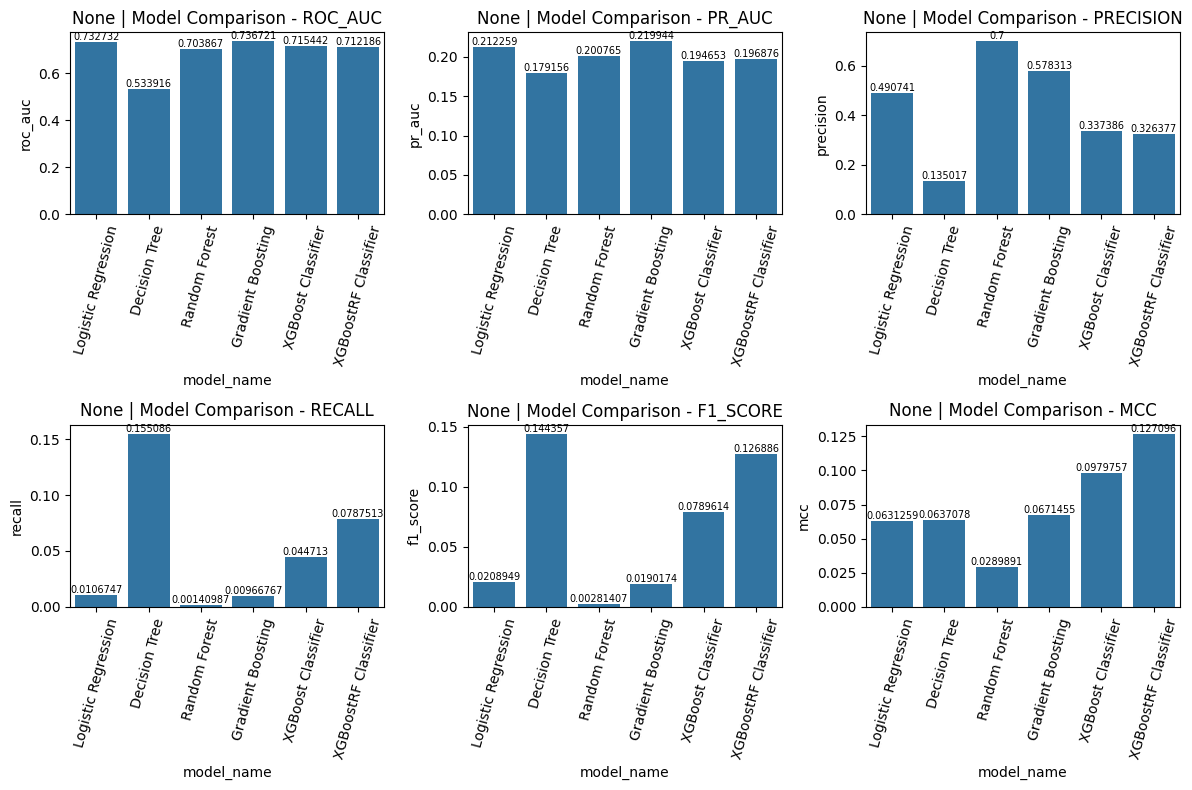

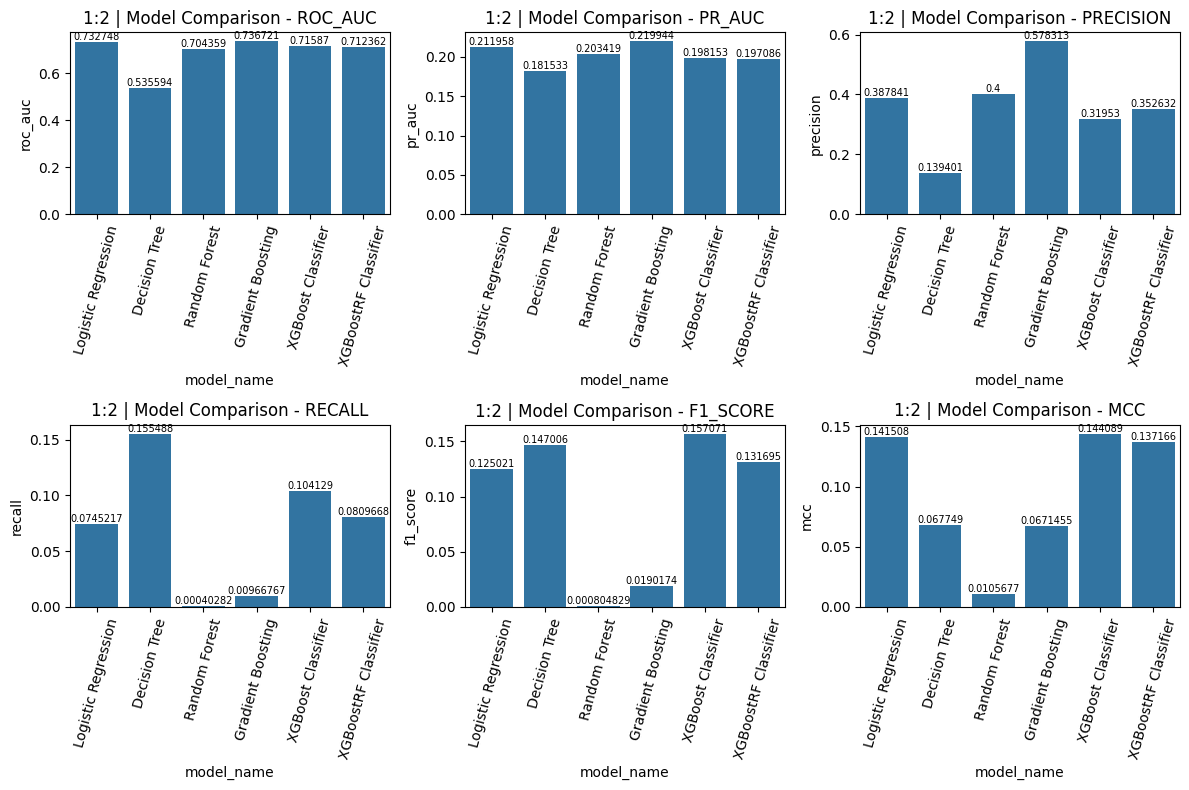

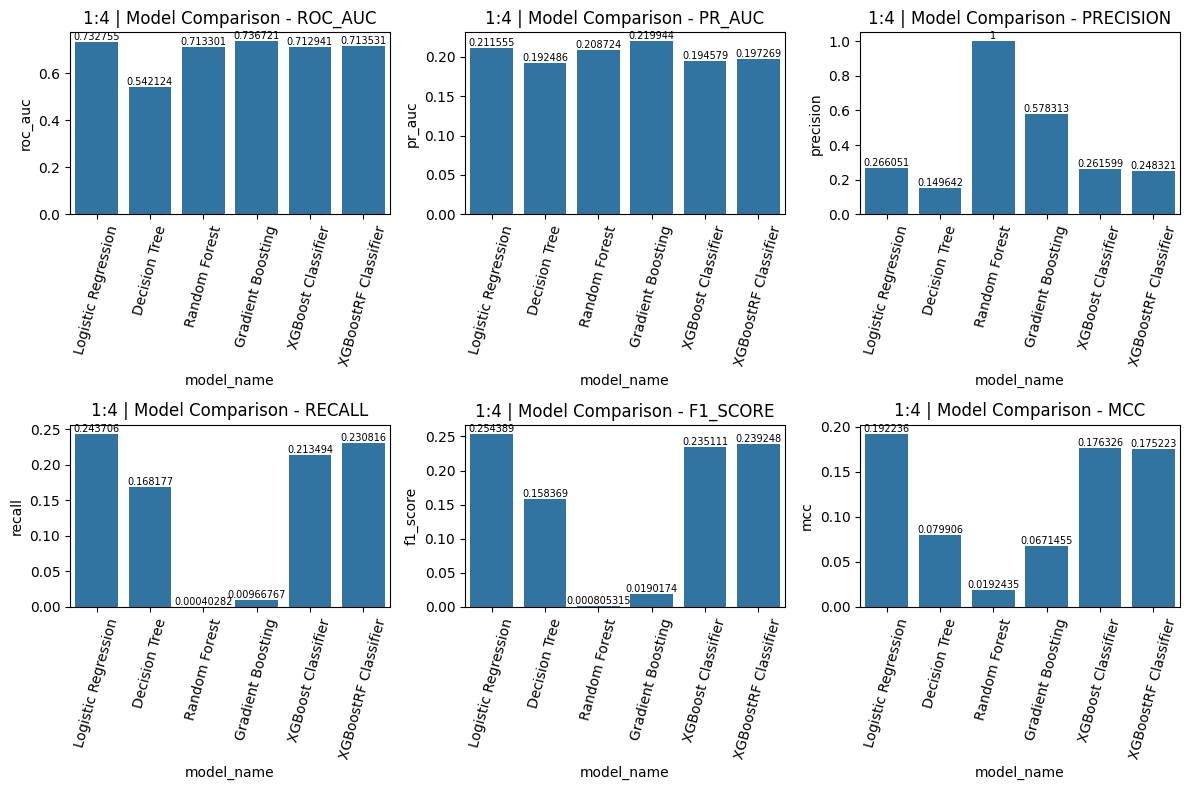

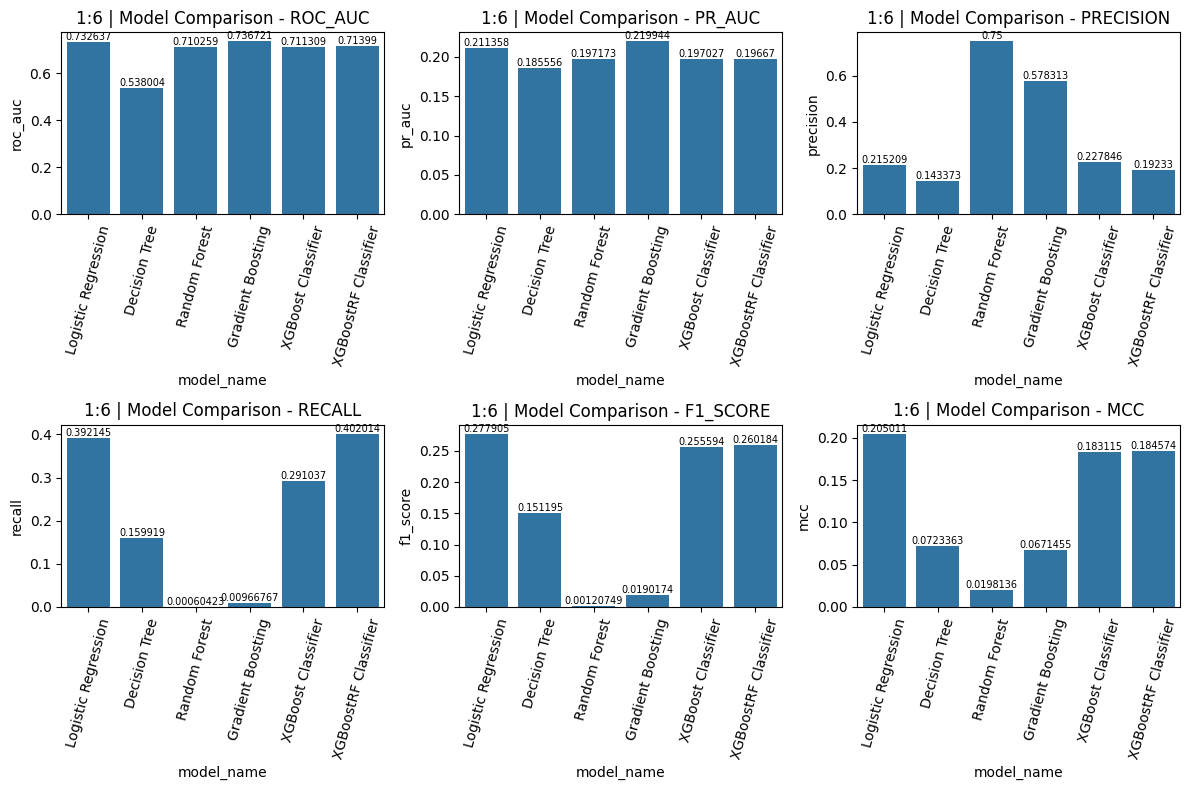

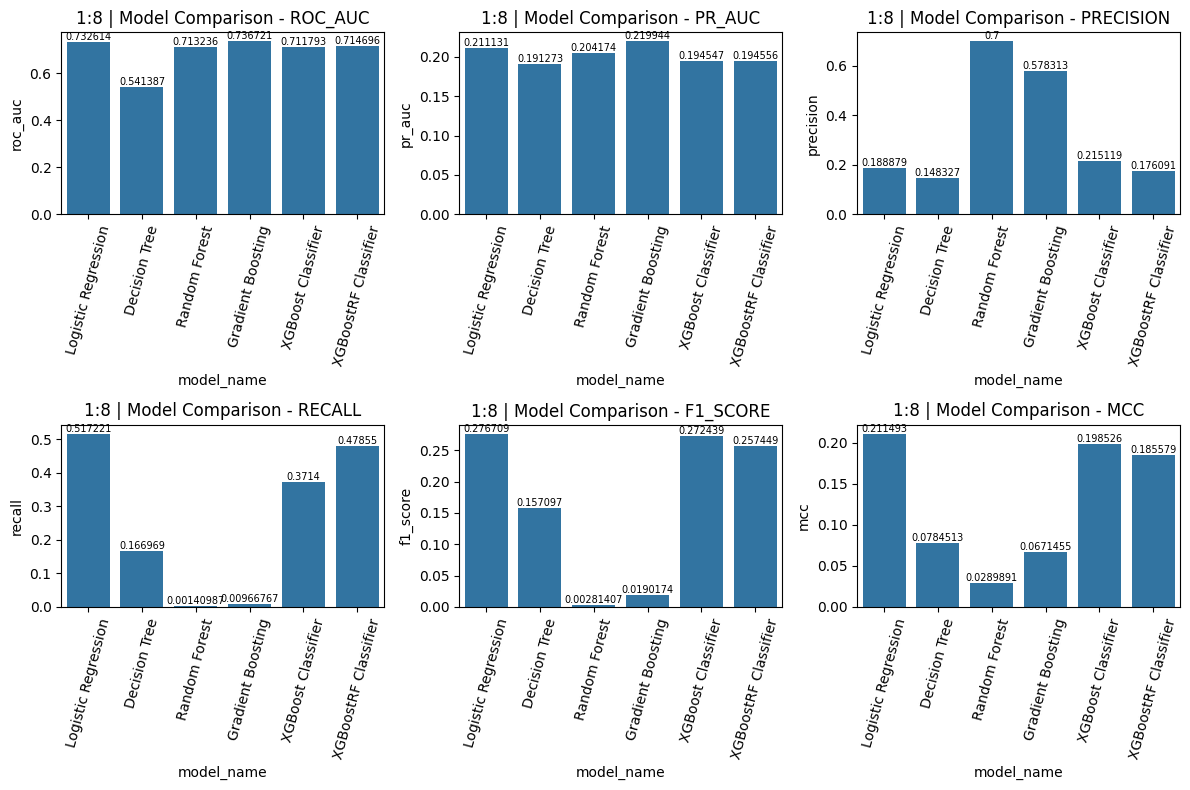

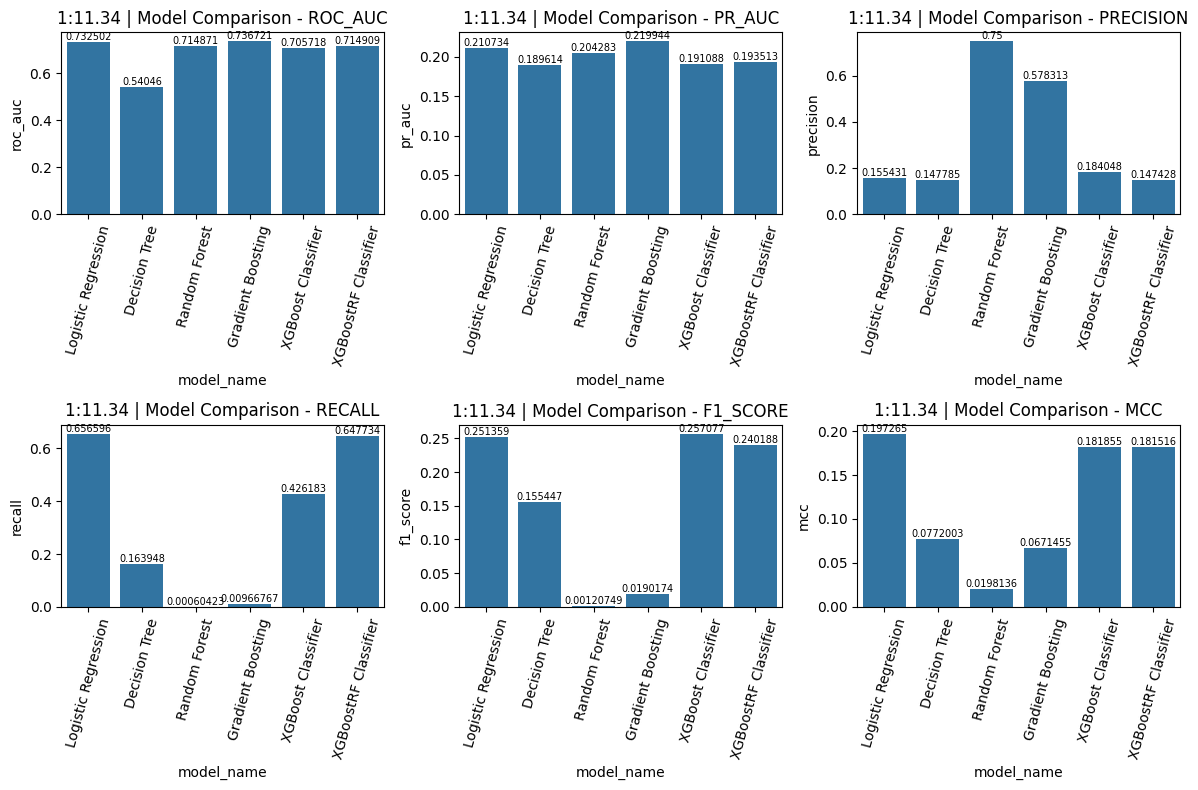

In [29]:
# Evaluating Models with different class weights

# Create a dict of models

weights = {'None': {0: 1.0, 1: 1.0},
    '1:2': {0: 1.0, 1: 2},
    '1:4': {0: 1.0, 1: 4},
    '1:6': {0: 1.0, 1: 6},
    '1:8': {0: 1.0, 1: 8},
    '1:11.34': {0: 1.0, 1: 11.34}}


for weight_name, weight_dict in weights.items():
    models = {
        'Logistic Regression': LogisticRegression(class_weight=weight_dict, max_iter=1000, random_state=69),
        'Decision Tree': DecisionTreeClassifier(class_weight=weight_dict, random_state=69),
        'Random Forest': RandomForestClassifier(class_weight=weight_dict, random_state=69, n_estimators=100),
        'Gradient Boosting': GradientBoostingClassifier(random_state=69),
        'XGBoost Classifier': XGBClassifier(scale_pos_weight=weight_dict[1], n_estimators=500),
        'XGBoostRF Classifier': XGBRFClassifier(scale_pos_weight=weight_dict[1], random_state=69)
    }

    results = []
    for model_name, model in models.items():
        print(f"Evaluating {model_name} with weight:{weight_name}...")
        result = evaluate_model(model, model_name, X_train, X_test, y_train, y_test)
        results.append(result)
        print(f"  Precision: {result['precision']:.4f}")
        print(f"  Recall: {result['recall']:.4f}")
        print(f"  F1 Score: {result['f1_score']:.4f}")
        print(f"  ROC AUC: {result['roc_auc']:.4f}")
        print(f"  PR AUC: {result['pr_auc']:.4f}")
        print(f"  MCC: {result['mcc']:.4f}")
        # print(f"  Classification Report:\n{result['classification_report']}\n")

    # Create results summary
    results_df = pd.DataFrame(results)
    results_df = results_df.drop('classification_report', axis=1)
    # results_df.to_csv('ml_results/model_comparison.csv', index=False)

    # Plot model comparison
    plt.figure(figsize=(12, 8))
    metrics = ['roc_auc', 'pr_auc', 'precision', 'recall', 'f1_score', 'mcc']
    for i, metric in enumerate(metrics):
        plt.subplot(2, 3, i+1)
        ax = sns.barplot(x='model_name', y=metric, data=results_df)
        ax.bar_label(ax.containers[0],fontsize=7);
        plt.title(f'{weight_name} | Model Comparison - {metric.upper()}')
        plt.xticks(rotation=75)
        plt.tight_layout()

## Variants of Logistic Regression

Evaluating Logistic Regression LBF with weight:None...
[[56481    55]
 [ 4912    53]]
  Accuracy: 0.9192
  Precision: 0.4907
  Recall: 0.0107
  F1 Score: 0.0209
  ROC AUC: 0.7327
  PR AUC: 0.2123
  MCC: 0.0631
Evaluating Logistic Regression LBF with weight:1:7.7...
[[46070 10466]
 [ 2490  2475]]
  Accuracy: 0.7893
  Precision: 0.1913
  Recall: 0.4985
  F1 Score: 0.2764
  ROC AUC: 0.7327
  PR AUC: 0.2111
  MCC: 0.2094
Evaluating Logistic Regression LBF with weight:1:7.8...
[[45889 10647]
 [ 2449  2516]]
  Accuracy: 0.7871
  Precision: 0.1911
  Recall: 0.5067
  F1 Score: 0.2776
  ROC AUC: 0.7327
  PR AUC: 0.2110
  MCC: 0.2115
Evaluating Logistic Regression LBF with weight:1:7.9...
[[45695 10841]
 [ 2424  2541]]
  Accuracy: 0.7843
  Precision: 0.1899
  Recall: 0.5118
  F1 Score: 0.2770
  ROC AUC: 0.7326
  PR AUC: 0.2111
  MCC: 0.2113
Evaluating Logistic Regression LBF with weight:1:8...
[[45508 11028]
 [ 2397  2568]]
  Accuracy: 0.7817
  Precision: 0.1889
  Recall: 0.5172
  F1 Score: 0.27

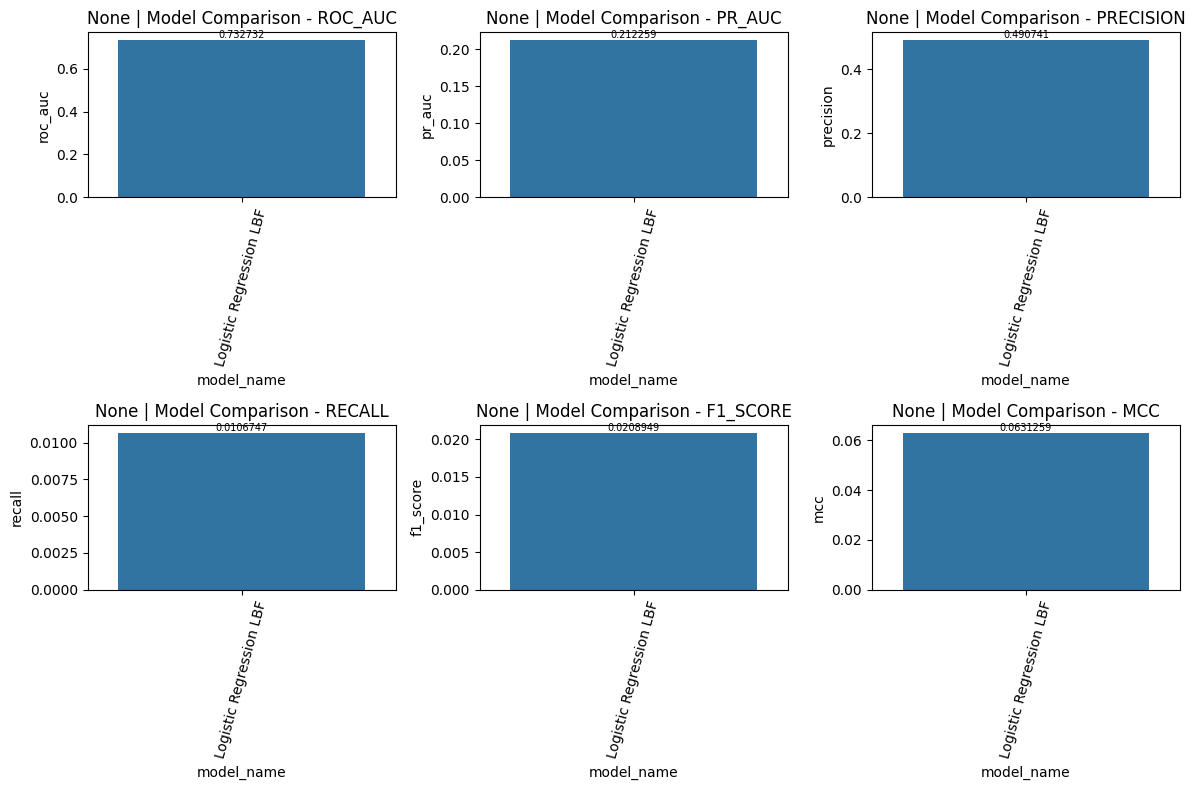

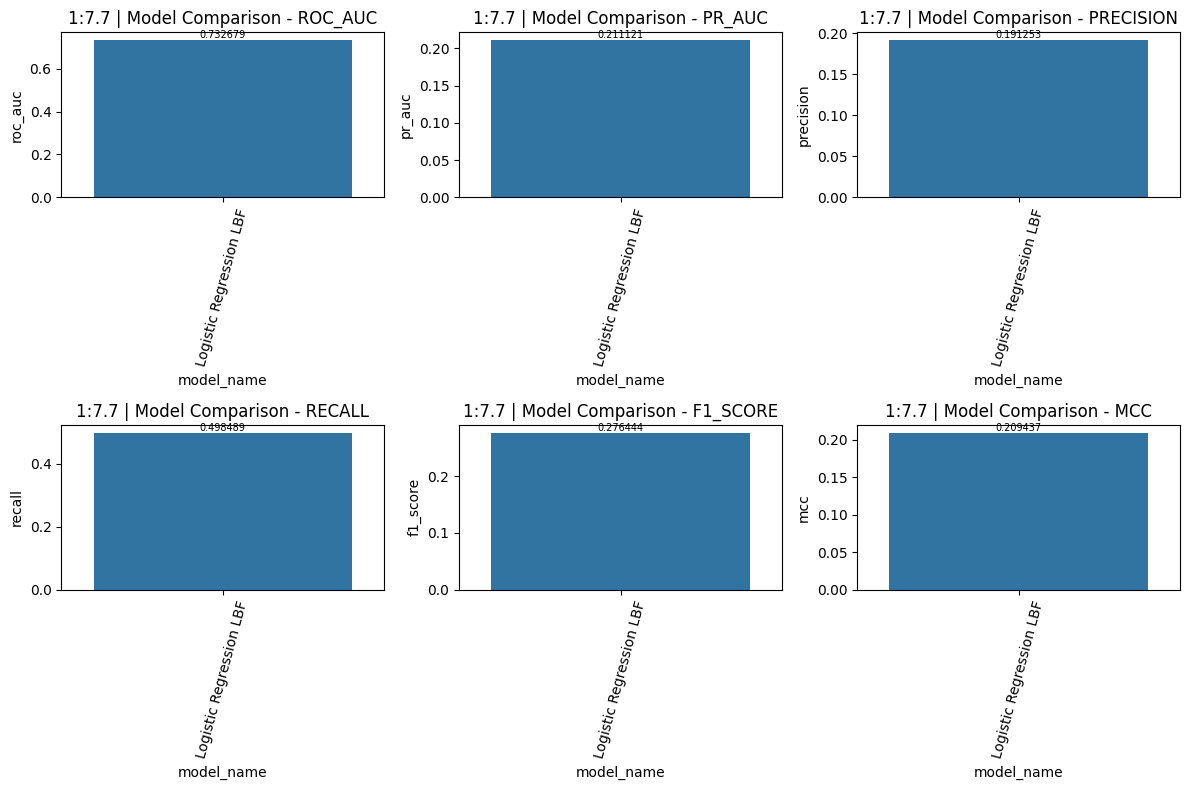

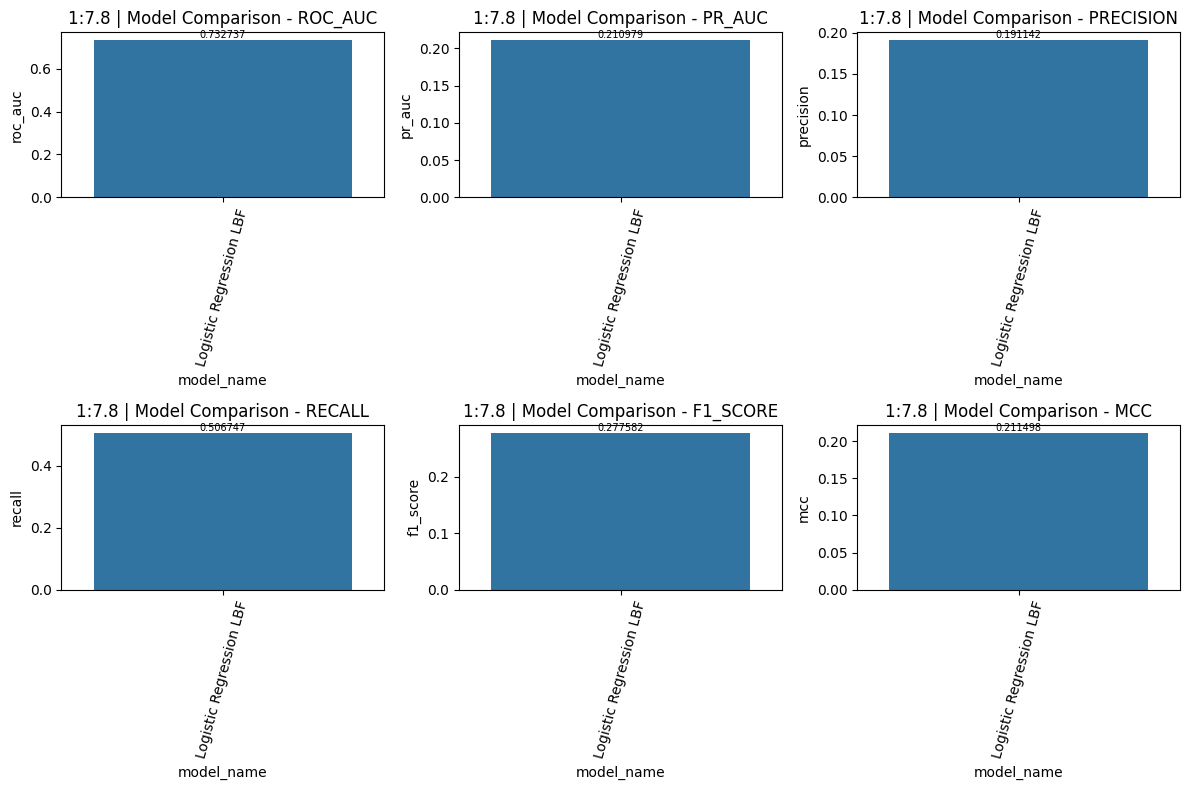

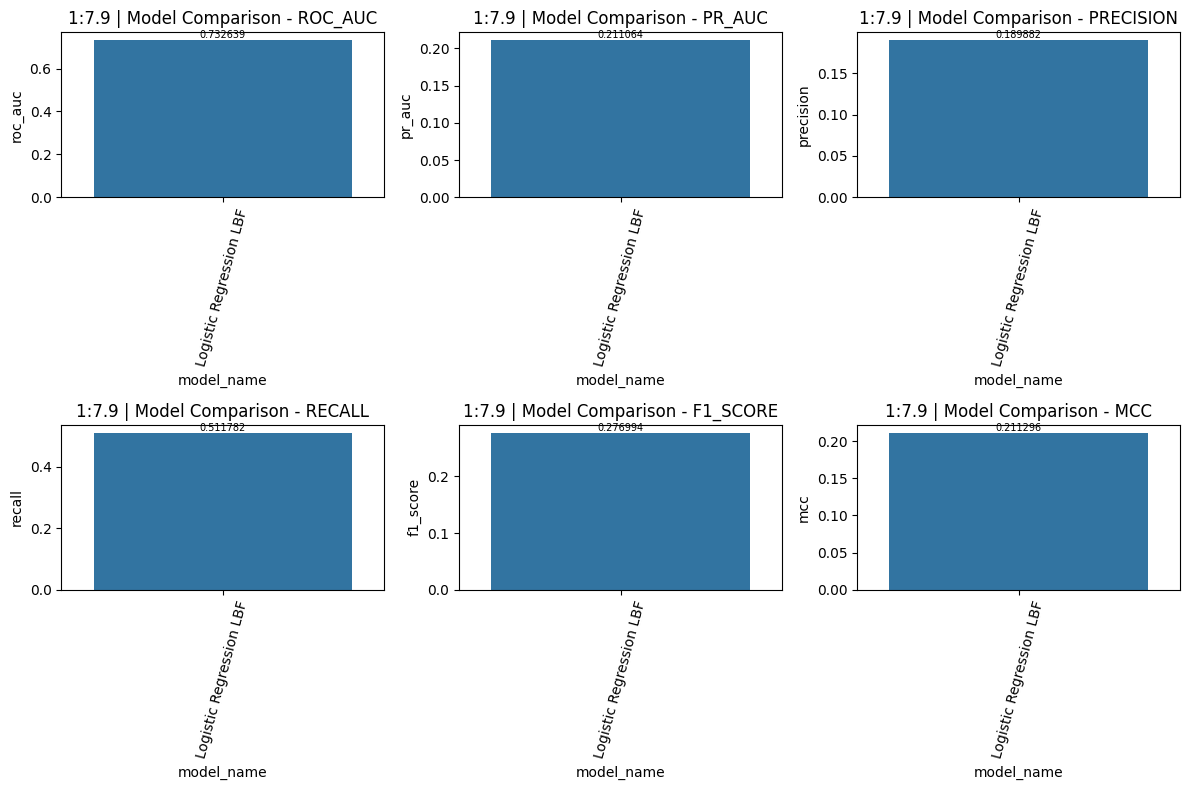

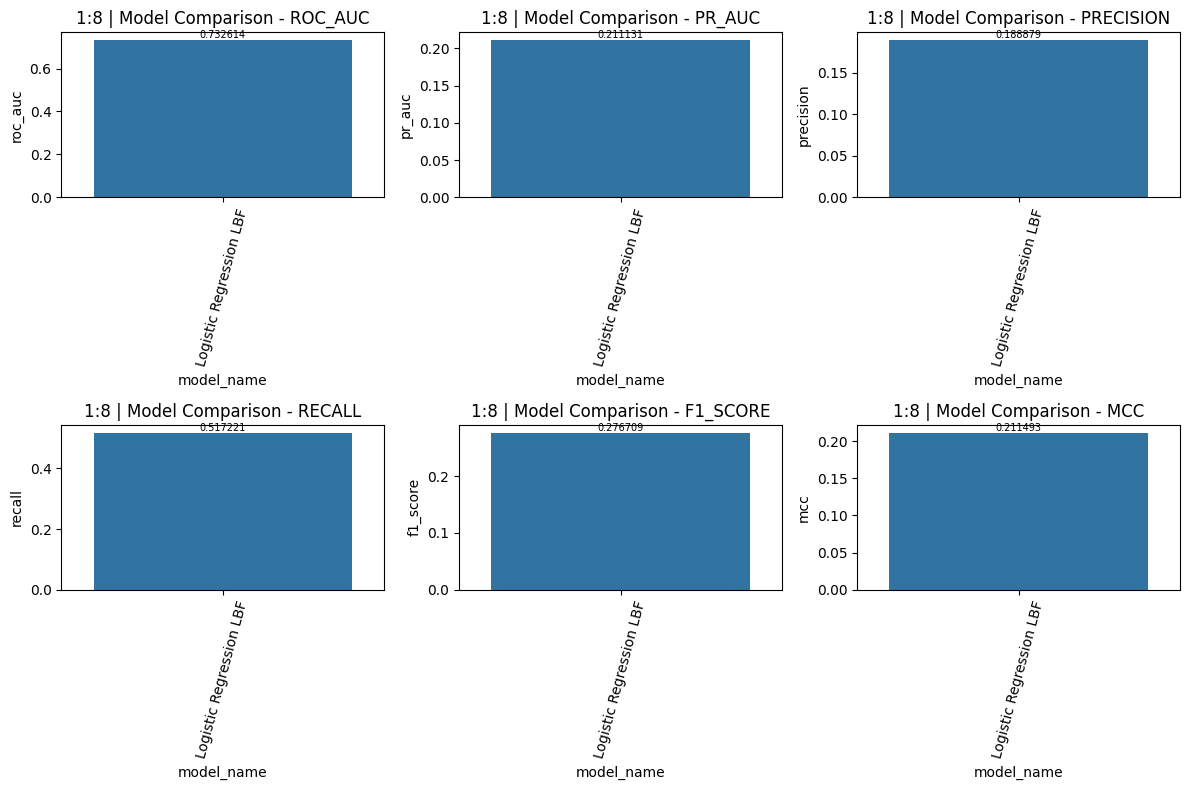

In [31]:
weights = {'None': {0: 1.0, 1: 1.0},
           '1:7.7': {0: 1.0, 1: 7.7},
           '1:7.8': {0: 1.0, 1: 7.8},
           '1:7.9': {0: 1.0, 1: 7.9},
    '1:8': {0: 1.0, 1: 8},
}


for weight_name, weight_dict in weights.items():
    models = {
        'Logistic Regression LBF': LogisticRegression(class_weight=weight_dict, max_iter=1000, random_state=69, solver='lbfgs'),
        }

    results = []
    for model_name, model in models.items():
        print(f"Evaluating {model_name} with weight:{weight_name}...")

        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        # Calculate metrics
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        mcc = matthews_corrcoef(y_test, y_pred)

        # Create classification report
        report = classification_report(y_test, y_pred)

        precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall_curve, precision_curve)

        # Create confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        print(cm)
    
        result = {
        'model_name': model_name,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'mcc': mcc,
        'classification_report': report}

        results.append(result)
        print(f"  Accuracy: {result['accuracy']:.4f}")
        print(f"  Precision: {result['precision']:.4f}")
        print(f"  Recall: {result['recall']:.4f}")
        print(f"  F1 Score: {result['f1_score']:.4f}")
        print(f"  ROC AUC: {result['roc_auc']:.4f}")
        print(f"  PR AUC: {result['pr_auc']:.4f}")
        print(f"  MCC: {result['mcc']:.4f}")
        # print(f"  Classification Report:\n{result['classification_report']}\n")

    # Create results summary
    results_df = pd.DataFrame(results)
    results_df = results_df.drop('classification_report', axis=1)
    # results_df.to_csv('ml_results/model_comparison.csv', index=False)

    # Plot model comparison
    plt.figure(figsize=(12, 8))
    metrics = ['roc_auc', 'pr_auc', 'precision', 'recall', 'f1_score', 'mcc']
    for i, metric in enumerate(metrics):
        plt.subplot(2, 3, i+1)
        ax = sns.barplot(x='model_name', y=metric, data=results_df)
        ax.bar_label(ax.containers[0],fontsize=7);
        plt.title(f'{weight_name} | Model Comparison - {metric.upper()}')
        plt.xticks(rotation=75)
        plt.tight_layout()

## Different Models

In [32]:
X_train.describe()

,ohe__catimp__NAME_TYPE_SUITE_Children,ohe__catimp__NAME_TYPE_SUITE_Family,ohe__catimp__NAME_TYPE_SUITE_Group of people,ohe__catimp__NAME_TYPE_SUITE_Other_A,ohe__catimp__NAME_TYPE_SUITE_Other_B,"ohe__catimp__NAME_TYPE_SUITE_Spouse, partner",ohe__catimp__NAME_TYPE_SUITE_Unaccompanied,ohe__catimp__NAME_INCOME_TYPE_Businessman,ohe__catimp__NAME_INCOME_TYPE_Commercial associate,ohe__catimp__NAME_INCOME_TYPE_Pensioner,...,remainder__numimp__missingindicator_AMT_REQ_CREDIT_BUREAU_WEEK,remainder__numimp__missingindicator_AMT_REQ_CREDIT_BUREAU_MON,remainder__numimp__missingindicator_AMT_REQ_CREDIT_BUREAU_QRT,remainder__numimp__missingindicator_AMT_REQ_CREDIT_BUREAU_YEAR,remainder__catimp__NAME_CONTRACT_TYPE,remainder__catimp__CODE_GENDER,remainder__catimp__FLAG_OWN_CAR,remainder__catimp__FLAG_OWN_REALTY,remainder__catimp__missingindicator_NAME_TYPE_SUITE,remainder__catimp__missingindicator_OCCUPATION_TYPE
count,246001.000000,246001.000000,246001.000000,246001.000000,246001.000000,246001.000000,246001.000000,246001.000000,246001.000000,246001.000000,...,246001.000000,246001.000000,246001.000000,246001.000000,246001.000000,246001.000000,246001.000000,246001.000000,246001.000000,246001.000000
mean,0.010618,0.130711,0.000907,0.002817,0.005715,0.037032,0.812200,0.000033,0.232320,0.180707,...,0.135414,0.135414,0.135414,0.135414,0.094796,0.342186,0.340145,0.693489,0.004122,0.132544
std,0.102495,0.337085,0.030095,0.053001,0.075384,0.188842,0.390553,0.005703,0.422313,0.384776,...,0.342166,0.342166,0.342166,0.342166,0.292934,0.474442,0.473759,0.461045,0.064070,0.339082
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Evaluating Logistic Regression with weight:None...
[[56481    55]
 [ 4912    53]]
  Precision: 0.4907
  Recall: 0.0107
  F1 Score: 0.0209
  MCC: 0.0631
Evaluating XGBoost Classifier with weight:None...
[[47295  9241]
 [ 2820  2145]]
  Precision: 0.1884
  Recall: 0.4320
  F1 Score: 0.2624
  MCC: 0.1884
Evaluating Gaussian Naive Bayes with weight:None...
[[ 6473 50063]
 [  370  4595]]
  Precision: 0.0841
  Recall: 0.9255
  F1 Score: 0.1541
  MCC: 0.0346
Evaluating Ridge Classifier with weight:None...


/Users/jacobwarchola/Desktop/loan_project/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jacobwarchola/Desktop/loan_project/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jacobwarchola/Desktop/loan_project/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, m

[[56536     0]
 [ 4965     0]]
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  MCC: 0.0000
Evaluating SGD Classifier with weight:None...
[[56505    31]
 [ 4933    32]]
  Precision: 0.5079
  Recall: 0.0064
  F1 Score: 0.0127
  MCC: 0.0502
Evaluating Logistic Regression with weight:1:8...
[[45508 11028]
 [ 2397  2568]]
  Precision: 0.1889
  Recall: 0.5172
  F1 Score: 0.2767
  MCC: 0.2115
Evaluating XGBoost Classifier with weight:1:8...
[[47295  9241]
 [ 2820  2145]]
  Precision: 0.1884
  Recall: 0.4320
  F1 Score: 0.2624
  MCC: 0.1884
Evaluating Gaussian Naive Bayes with weight:1:8...
[[ 6473 50063]
 [  370  4595]]
  Precision: 0.0841
  Recall: 0.9255
  F1 Score: 0.1541
  MCC: 0.0346
Evaluating Ridge Classifier with weight:1:8...
[[45598 10938]
 [ 2417  2548]]
  Precision: 0.1889
  Recall: 0.5132
  F1 Score: 0.2762
  MCC: 0.2105
Evaluating SGD Classifier with weight:1:8...
[[39627 16909]
 [ 1916  3049]]
  Precision: 0.1528
  Recall: 0.6141
  F1 Score: 0.2447
  MCC: 0.1833
Evalu

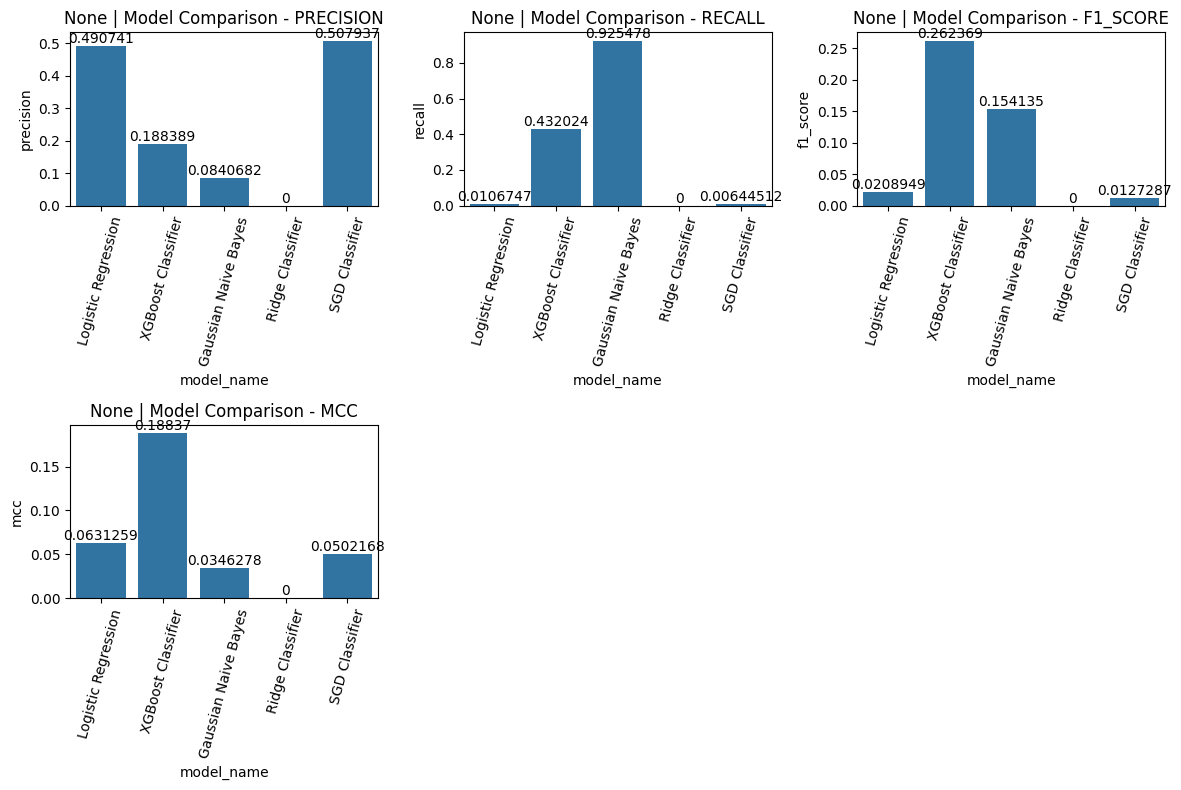

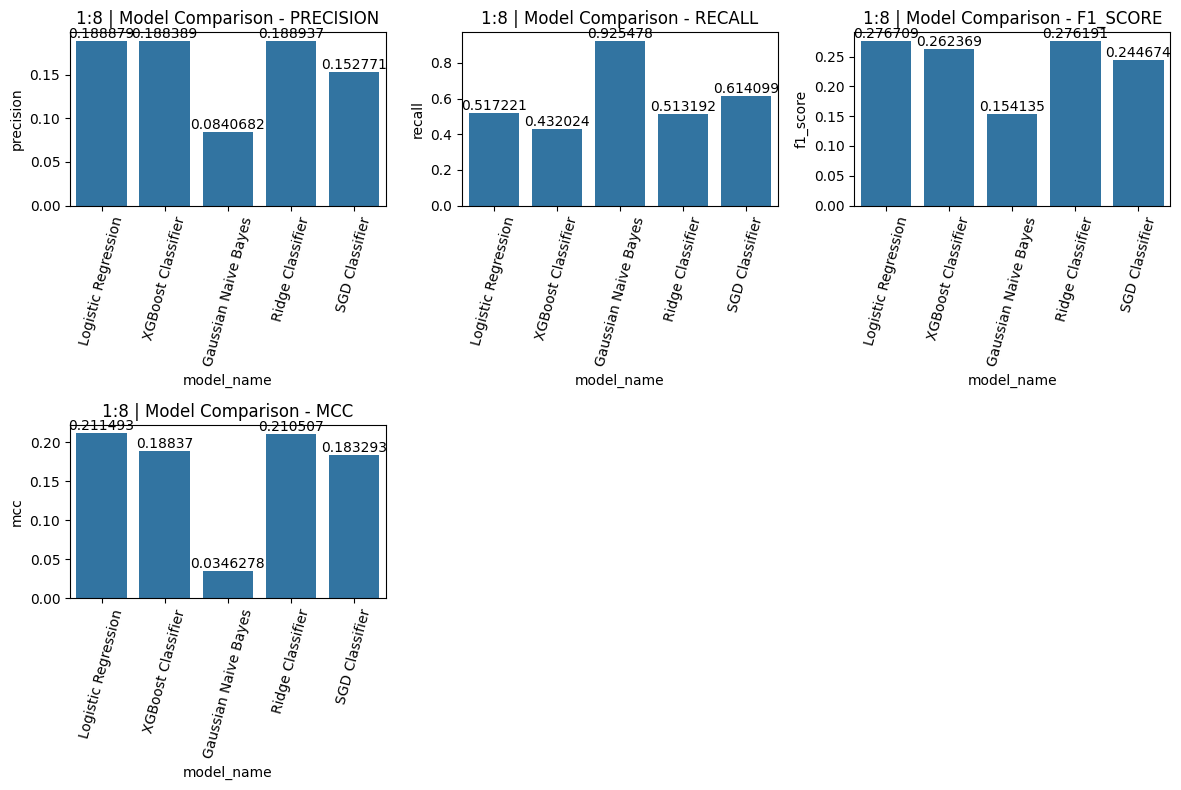

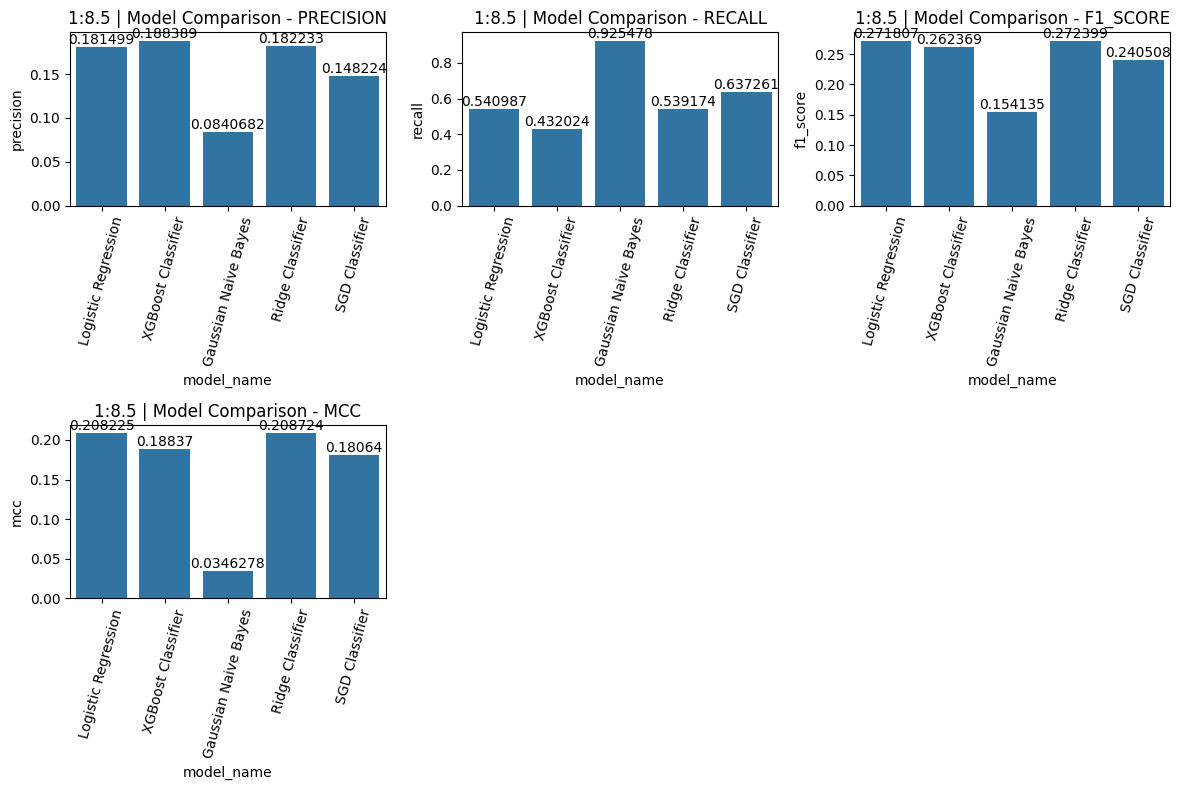

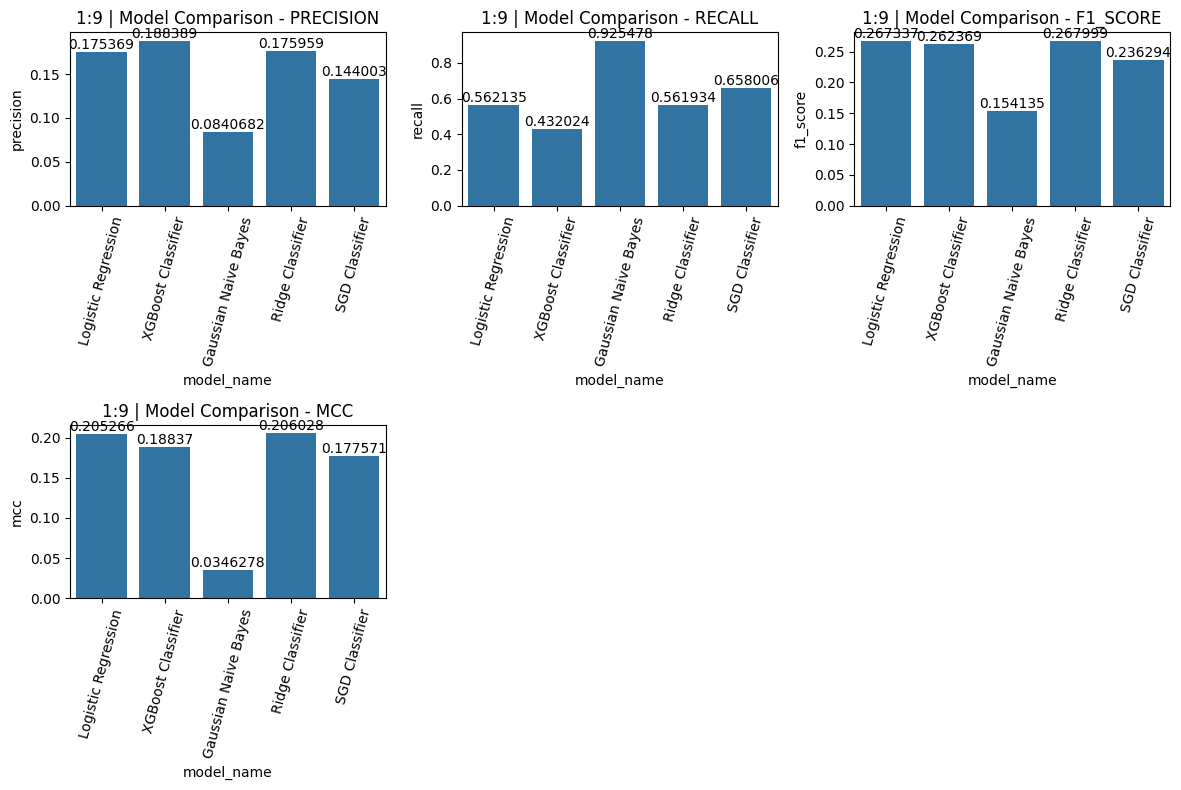

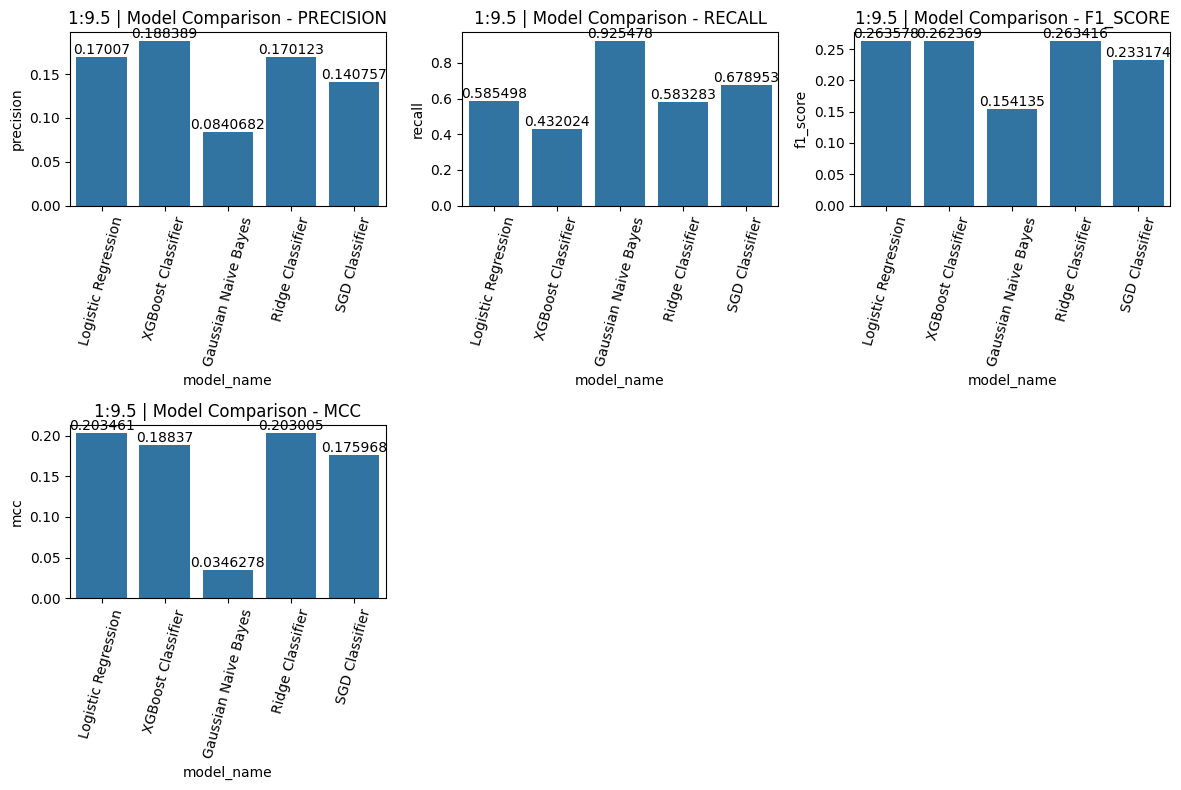

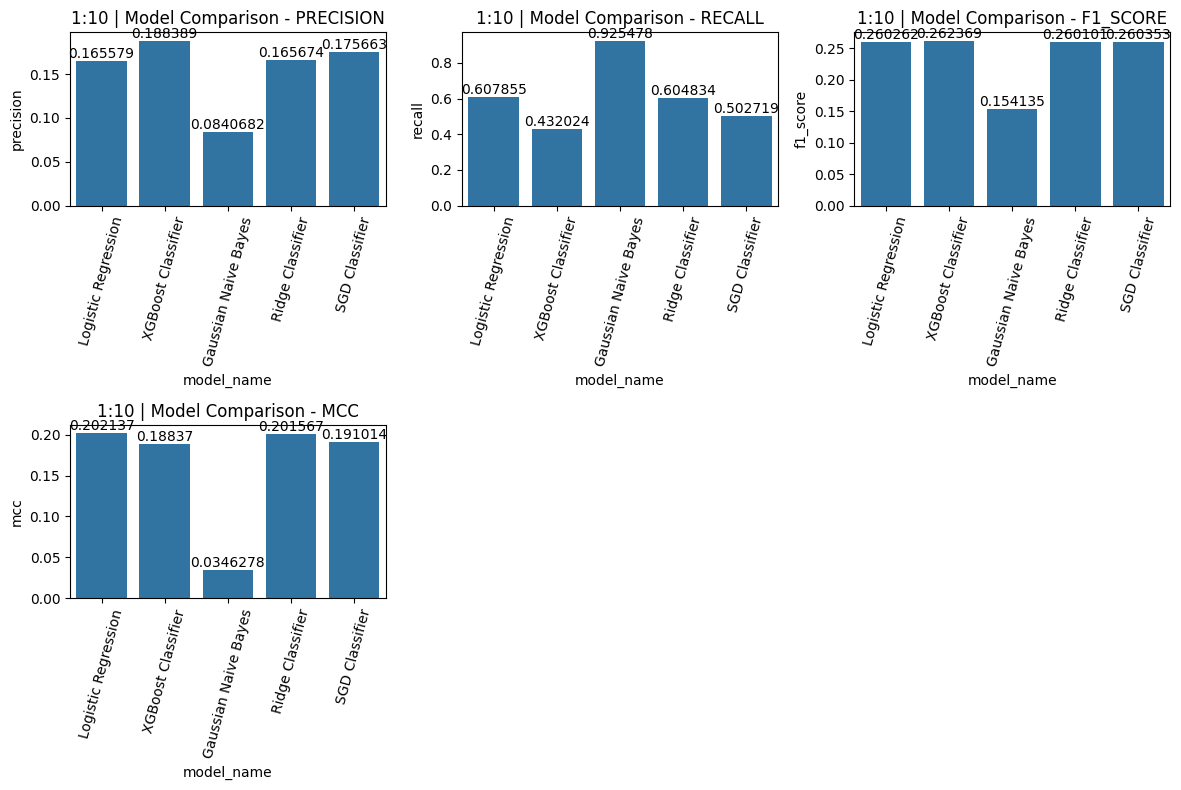

In [33]:
# Evaluating Models with different class weights

# Create a dict of models

from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.linear_model import RidgeClassifier, SGDClassifier

weights = {'None': {0: 1.0, 1: 1.0},
    '1:8': {0: 1.0, 1: 8},
    '1:8.5': {0: 1.0, 1: 8.5},
    '1:9': {0: 1.0, 1: 9},
    '1:9.5': {0: 1.0, 1: 9.5},
    '1:10': {0: 1.0, 1: 10}}


for weight_name, weight_dict in weights.items():
    models = {
        'Logistic Regression': LogisticRegression(class_weight=weight_dict, max_iter=1000, random_state=69),
        'XGBoost Classifier': XGBClassifier(scale_pos_weight=11, n_estimators=500),
        'Gaussian Naive Bayes': GaussianNB(),
        # 'Complement Naive Bayes': ComplementNB(),
        'Ridge Classifier': RidgeClassifier(random_state=69, class_weight=weight_dict),
        'SGD Classifier': SGDClassifier(loss='log_loss', random_state=69, class_weight=weight_dict)
    }

    results = []
    for model_name, model in models.items():
        print(f"Evaluating {model_name} with weight:{weight_name}...")

        model.fit(X_train, y_train)

        # Predict the labels for the test set
        y_pred = model.predict(X_test)

        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        mcc = matthews_corrcoef(y_test, y_pred)

        # Create classification report
        report = classification_report(y_test, y_pred)

        # Create confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        print(cm)

        result = {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'mcc': mcc,
        'classification_report': report}

        results.append(result)
        print(f"  Precision: {result['precision']:.4f}")
        print(f"  Recall: {result['recall']:.4f}")
        print(f"  F1 Score: {result['f1_score']:.4f}")
        print(f"  MCC: {result['mcc']:.4f}")
        # print(f"  Classification Report:\n{result['classification_report']}\n")

    # Create results summary
    results_df = pd.DataFrame(results)
    results_df = results_df.drop('classification_report', axis=1)
    # results_df.to_csv('ml_results/model_comparison.csv', index=False)

    # Plot model comparison
    plt.figure(figsize=(12, 8))
    metrics = ['precision', 'recall', 'f1_score', 'mcc']
    for i, metric in enumerate(metrics):
        plt.subplot(2, 3, i+1)
        ax = sns.barplot(x='model_name', y=metric, data=results_df)
        ax.bar_label(ax.containers[0],fontsize=10);
        plt.title(f'{weight_name} | Model Comparison - {metric.upper()}')
        plt.xticks(rotation=75)
        plt.tight_layout()

## Smote Resampling


Evaluating models with SMOTE for handling class imbalance...
Original dataset shape Counter({0: 226143, 1: 19858})
Resampled dataset shape Counter({1: 226143, 0: 226143})
Evaluating Logistic Regression SMOTE...
[[40866 15670]
 [ 2103  2862]]
  Precision: 0.1544
  Recall: 0.5764
  F1 Score: 0.2436
  ROC AUC: 0.7024
  PR AUC: 0.1889
  Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.72      0.82     56536
           1       0.15      0.58      0.24      4965

    accuracy                           0.71     61501
   macro avg       0.55      0.65      0.53     61501
weighted avg       0.89      0.71      0.77     61501


Evaluating Decision Tree SMOTE...
[[50266  6270]
 [ 4078   887]]
  Precision: 0.1239
  Recall: 0.1787
  F1 Score: 0.1463
  ROC AUC: 0.5339
  PR AUC: 0.1844
  Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.89      0.91     56536
           1       0.12

/Users/jacobwarchola/Desktop/loan_project/venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:03:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "randomstate" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[[56348   188]
 [ 4823   142]]
  Precision: 0.4303
  Recall: 0.0286
  F1 Score: 0.0536
  ROC AUC: 0.7289
  PR AUC: 0.2104
  Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56536
           1       0.43      0.03      0.05      4965

    accuracy                           0.92     61501
   macro avg       0.68      0.51      0.51     61501
weighted avg       0.88      0.92      0.88     61501


Evaluating XGBoostRF Classifier SMOTE...
[[43985 12551]
 [ 2772  2193]]
  Precision: 0.1487
  Recall: 0.4417
  F1 Score: 0.2225
  ROC AUC: 0.6726
  PR AUC: 0.1936
  Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.78      0.85     56536
           1       0.15      0.44      0.22      4965

    accuracy                           0.75     61501
   macro avg       0.54      0.61      0.54     61501
weighted avg       0.88      0.75      0.80     61501




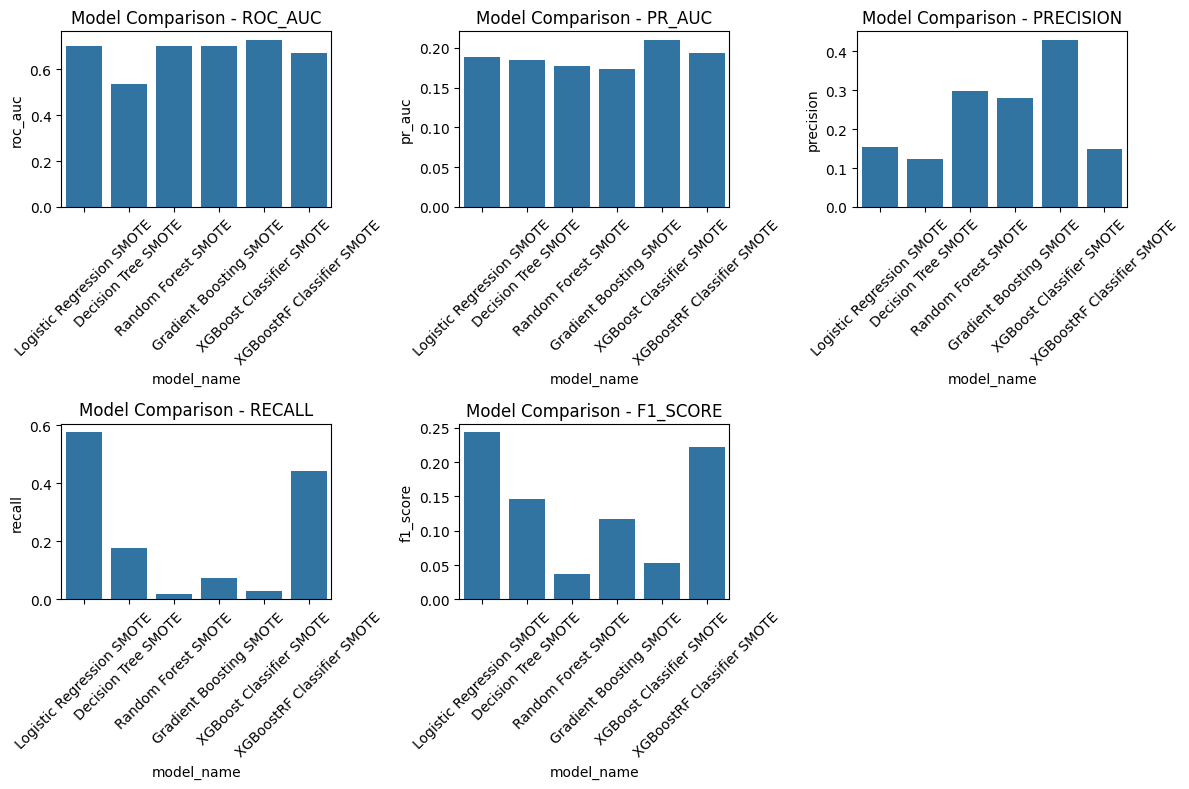

In [35]:
# Try SMOTE for handling class imbalance
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from collections import Counter

print("\nEvaluating models with SMOTE for handling class imbalance...")

model_smote = {
    'Logistic Regression SMOTE': LogisticRegression(max_iter=1000, random_state=69),
    'Decision Tree SMOTE': DecisionTreeClassifier(random_state=69),
    'Random Forest SMOTE': RandomForestClassifier(random_state=69, n_estimators=100),
    'Gradient Boosting SMOTE': GradientBoostingClassifier(random_state=69),
    'XGBoost Classifier SMOTE': XGBClassifier(randomstate=69),
    'XGBoostRF Classifier SMOTE': XGBRFClassifier()
}
smote_results = []

sm = SMOTE(random_state=69)
print('Original dataset shape %s' % Counter(y_train))
X_res, y_res = sm.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

for model_name, model in model_smote.items():

    print(f"Evaluating {model_name}...")
    result = evaluate_model(model, model_name, X_res, X_test, y_res, y_test)
    smote_results.append(result)
    print(f"  Precision: {result['precision']:.4f}")
    print(f"  Recall: {result['recall']:.4f}")
    print(f"  F1 Score: {result['f1_score']:.4f}")
    print(f"  ROC AUC: {result['roc_auc']:.4f}")
    print(f"  PR AUC: {result['pr_auc']:.4f}")
    print(f"  Classification Report:\n{result['classification_report']}\n")

# Create results summary
smote_results_df = pd.DataFrame(smote_results)
smote_results_df = smote_results_df.drop('classification_report', axis=1)
# results_df.to_csv('ml_results/model_comparison.csv', index=False)

# Plot model comparison
plt.figure(figsize=(12, 8))
metrics = ['roc_auc', 'pr_auc', 'precision', 'recall', 'f1_score']
for i, metric in enumerate(metrics):
    plt.subplot(2, 3, i+1)
    sns.barplot(x='model_name', y=metric, data=smote_results_df)
    plt.title(f'Model Comparison - {metric.upper()}')
    plt.xticks(rotation=45)
    plt.tight_layout()

## Undersampling


Evaluating models with RUS for handling class imbalance...
Original dataset shape Counter({0: 226143, 1: 19858})
Resampled dataset shape Counter({0: 19858, 1: 19858})
Evaluating Logistic Regression RUS...
[[38492 18044]
 [ 1679  3286]]
  Precision: 0.1541
  Recall: 0.6618
  F1 Score: 0.2499
  ROC AUC: 0.7313
  PR AUC: 0.2088
  MCC: 0.1961
  Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.68      0.80     56536
           1       0.15      0.66      0.25      4965

    accuracy                           0.68     61501
   macro avg       0.56      0.67      0.52     61501
weighted avg       0.89      0.68      0.75     61501


Evaluating Decision Tree RUS...
[[32811 23725]
 [ 2076  2889]]
  Precision: 0.1086
  Recall: 0.5819
  F1 Score: 0.1830
  ROC AUC: 0.5811
  PR AUC: 0.3621
  MCC: 0.0892
  Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.58      0.72     56536
   

ValueError: Length of list vectors must match length of `data` when both are used, but `data` has length 5 and the vector passed to `y` has length 6.

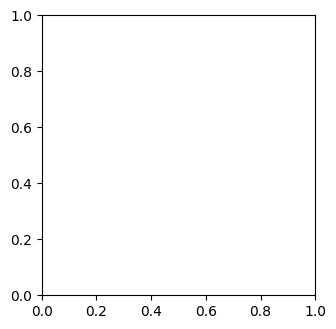

In [ ]:
# Try undersampling for handling class imbalance

from imblearn.under_sampling import RandomUnderSampler

print("\nEvaluating models with RUS for handling class imbalance...")

model_rus = {
    'Logistic Regression RUS': LogisticRegression(max_iter=1000, random_state=69),
    'Decision Tree RUS': DecisionTreeClassifier(random_state=69),
    'Random Forest RUS': RandomForestClassifier(random_state=69, n_estimators=100),
    'Gradient Boosting RUS': GradientBoostingClassifier(random_state=69),
    'XGBoost Classifier RUS': XGBClassifier(),
    'XGBoostRF Classifier RUS': XGBRFClassifier()
}
rus_results = []

ru = RandomUnderSampler(random_state=69)
print('Original dataset shape %s' % Counter(y_train))
X_res, y_res = ru.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))


for model_name, model in model_rus.items():

    print(f"Evaluating {model_name}...")
    result = evaluate_model(model, model_name, X_res, X_test, y_res, y_test)
    rus_results.append(result)
    print(f"  Precision: {result['precision']:.4f}")
    print(f"  Recall: {result['recall']:.4f}")
    print(f"  F1 Score: {result['f1_score']:.4f}")
    print(f"  ROC AUC: {result['roc_auc']:.4f}")
    print(f"  PR AUC: {result['pr_auc']:.4f}")
    print(f"  MCC: {result['mcc']:.4f}")
    print(f"  Classification Report:\n{result['classification_report']}\n")

# Create results summary
rus_results_df = pd.DataFrame(rus_results)
rus_results_df = rus_results_df.drop('classification_report', axis=1)
# results_df.to_csv('ml_results/model_comparison.csv', index=False)

# Plot model comparison
plt.figure(figsize=(12, 8))
metrics = ['roc_auc', 'pr_auc', 'precision', 'recall', 'f1_score', 'mcc']
for i, metric in enumerate(metrics):
    plt.subplot(2, 3, i+1)
    ax = sns.barplot(x='model_name', y=metric, data=results_df)
    ax.bar_label(ax.containers[0],fontsize=7);
    plt.title(f'Model Comparison - {metric.upper()}')
    plt.xticks(rotation=45)
    plt.tight_layout()

In [ ]:
# Add resampling results to comparison
results.append(smote_result)
results.append(under_result)
results_df = pd.DataFrame(results)
results_df = results_df.drop('classification_report', axis=1)
# results_df.to_csv('ml_results/model_comparison_with_resampling.csv', index=False)

# Plot final model comparison
plt.figure(figsize=(14, 10))
metrics = ['roc_auc', 'precision', 'recall', 'f1_score']
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    sns.barplot(x='model_name', y=metric, data=results_df)
    plt.title(f'Model Comparison - {metric.upper()}')
    plt.xticks(rotation=45)
    plt.tight_layout()
# plt.savefig('ml_results/final_model_comparison.png')


## Class Weights and Undersampling


Evaluating models with RUS and Class Weights for handling class imbalance...
Original dataset shape Counter({0: 226143, 1: 19858})
Resampled dataset shape Counter({0: 198580, 1: 19858})
Evaluating LR | RUS & CW with weight:None...
[[56448    88]
 [ 4883    82]]
  Precision: 0.4824
  Recall: 0.0165
  F1 Score: 0.0319
  ROC AUC: 0.7328
  PR AUC: 0.2120
  MCC: 0.0776
Evaluating DT | RUS & CW with weight:None...
[[51072  5464]
 [ 4060   905]]
  Precision: 0.1421
  Recall: 0.1823
  F1 Score: 0.1597
  ROC AUC: 0.5428
  PR AUC: 0.1952
  MCC: 0.0766
Evaluating RF | RUS & CW with weight:None...
[[56533     3]
 [ 4952    13]]
  Precision: 0.8125
  Recall: 0.0026
  F1 Score: 0.0052
  ROC AUC: 0.7055
  PR AUC: 0.2030
  MCC: 0.0433
Evaluating GB | RUS & CW with weight:None...
[[56475    61]
 [ 4895    70]]
  Precision: 0.5344
  Recall: 0.0141
  F1 Score: 0.0275
  ROC AUC: 0.7364
  PR AUC: 0.2195
  MCC: 0.0769
Evaluating XBG | RUS & CW with weight:None...
[[56259   277]
 [ 4779   186]]
  Precision:

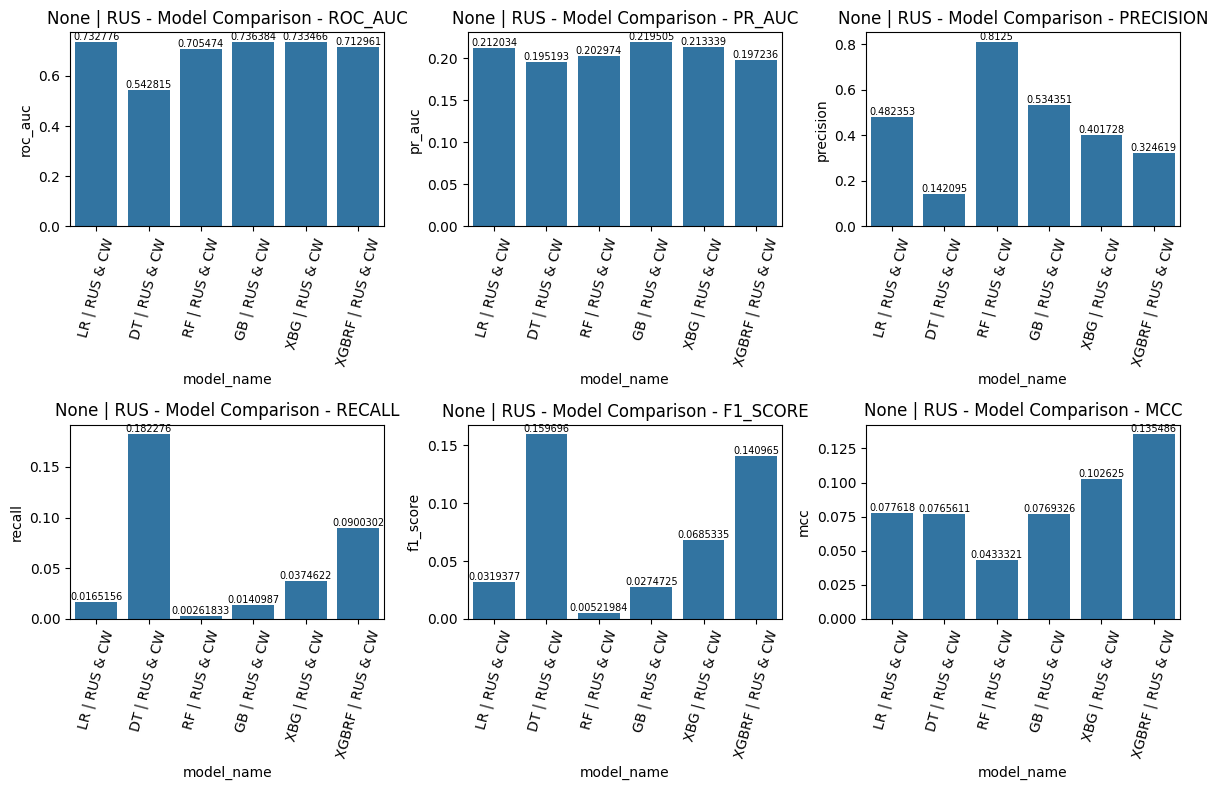

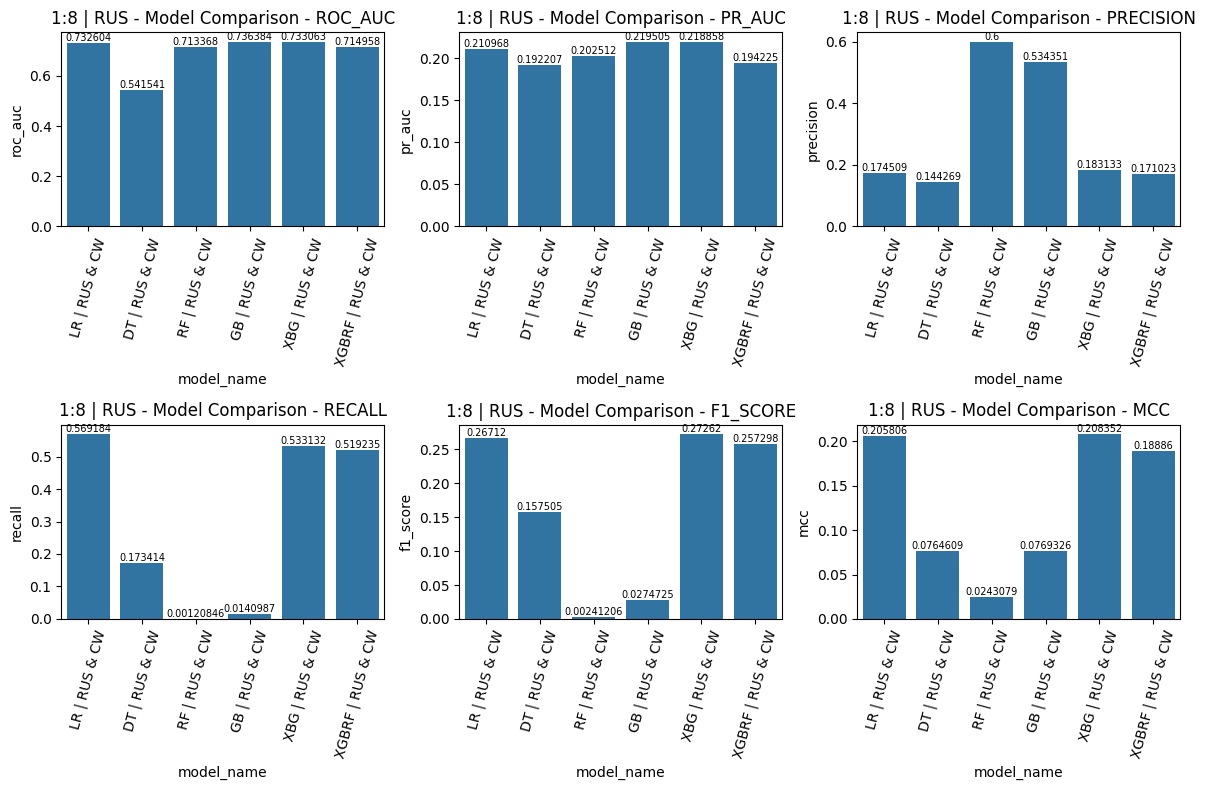

In [38]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

weights = {'None': {0: 1.0, 1: 1.0},
    # '1:1.1': {0: 1.0, 1: 1.1},
    # '1:1.2': {0: 1.0, 1: 1.2},
    # '1:1.3': {0: 1.0, 1: 1.3},
    # '1:2': {0: 1.0, 1: 2},
    '1:8': {0: 1.0, 1: 8}}

print("\nEvaluating models with RUS and Class Weights for handling class imbalance...")


ru = RandomUnderSampler(random_state=69, sampling_strategy=0.1)
print('Original dataset shape %s' % Counter(y_train))
X_rus, y_rus = ru.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_rus))


for weight_name, weight_dict in weights.items():

    model_rus = {
    'LR | RUS & CW': LogisticRegression(class_weight=weight_dict, max_iter=1000, random_state=69),
    'DT | RUS & CW': DecisionTreeClassifier(class_weight=weight_dict,random_state=69),
    'RF | RUS & CW': RandomForestClassifier(class_weight=weight_dict,random_state=69, n_estimators=100),
    'GB | RUS & CW': GradientBoostingClassifier(random_state=69),
    'XBG | RUS & CW': XGBClassifier(scale_pos_weight=weight_dict[1]),
    'XGBRF | RUS & CW': XGBRFClassifier(scale_pos_weight=weight_dict[1])}

    rus_results = []

    for model_name, model in model_rus.items():
        print(f"Evaluating {model_name} with weight:{weight_name}...")
        result = evaluate_model(model, model_name, X_rus, X_test, y_rus, y_test)
        rus_results.append(result)
        print(f"  Precision: {result['precision']:.4f}")
        print(f"  Recall: {result['recall']:.4f}")
        print(f"  F1 Score: {result['f1_score']:.4f}")
        print(f"  ROC AUC: {result['roc_auc']:.4f}")
        print(f"  PR AUC: {result['pr_auc']:.4f}")
        print(f"  MCC: {result['mcc']:.4f}")
        # print(f"  Classification Report:\n{result['classification_report']}\n")

    # Create results summary
    results_df = pd.DataFrame(rus_results)
    results_df = results_df.drop('classification_report', axis=1)
    # results_df.to_csv('ml_results/model_comparison.csv', index=False)

    # Plot model comparison
    plt.figure(figsize=(12, 8))
    metrics = ['roc_auc', 'pr_auc', 'precision', 'recall', 'f1_score', 'mcc']
    for i, metric in enumerate(metrics):
        plt.subplot(2, 3, i+1)
        ax = sns.barplot(x='model_name', y=metric, data=results_df)
        ax.bar_label(ax.containers[0],fontsize=7);
        plt.title(f'{weight_name} | RUS - Model Comparison - {metric.upper()}')
        plt.xticks(rotation=75)
        plt.tight_layout()


## AI strategy


Defining models to evaluate...

Evaluating models...
Evaluating Logistic Regression...
  ROC AUC: 0.7325
  Precision: 0.1552
  Recall: 0.6584
  F1 Score: 0.2512
  Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.69      0.80     56536
           1       0.16      0.66      0.25      4965

    accuracy                           0.68     61501
   macro avg       0.56      0.67      0.53     61501
weighted avg       0.89      0.68      0.75     61501


Evaluating Decision Tree...
  ROC AUC: 0.5368
  Precision: 0.1412
  Recall: 0.1579
  F1 Score: 0.1491
  Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.92     56536
           1       0.14      0.16      0.15      4965

    accuracy                           0.85     61501
   macro avg       0.53      0.54      0.53     61501
weighted avg       0.86      0.85      0.86     61501


Evaluating Random Forest...
  

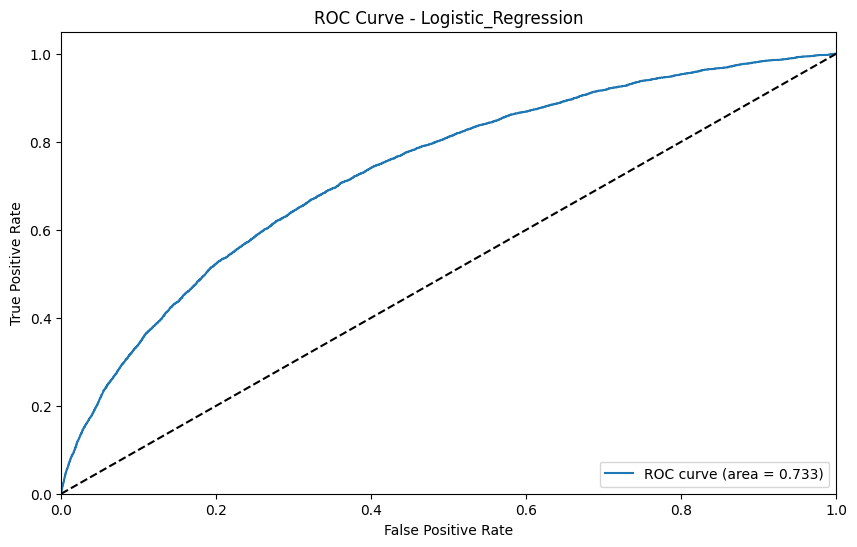

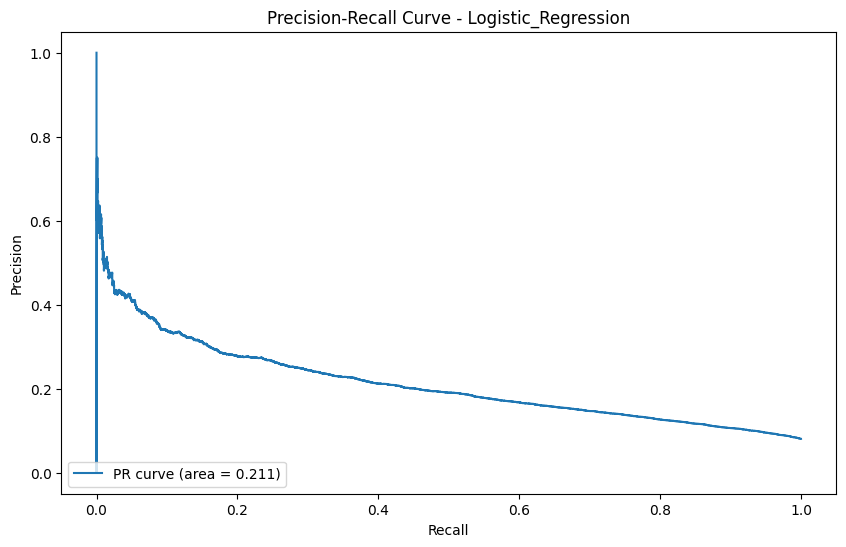

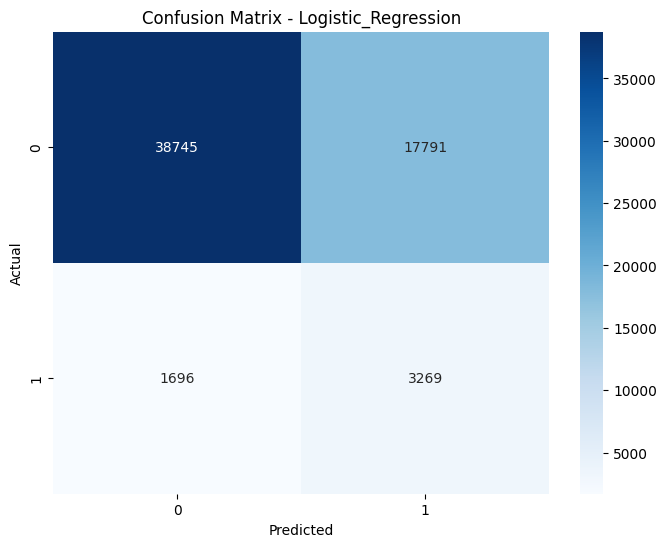

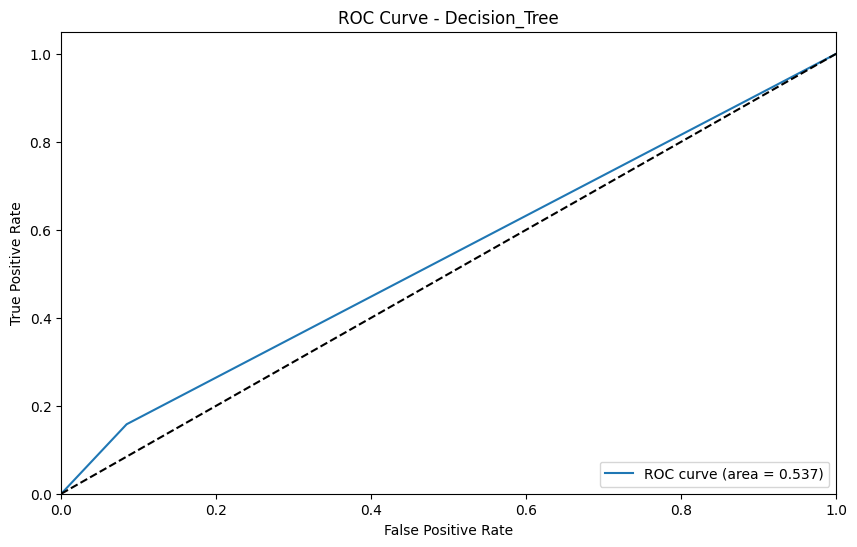

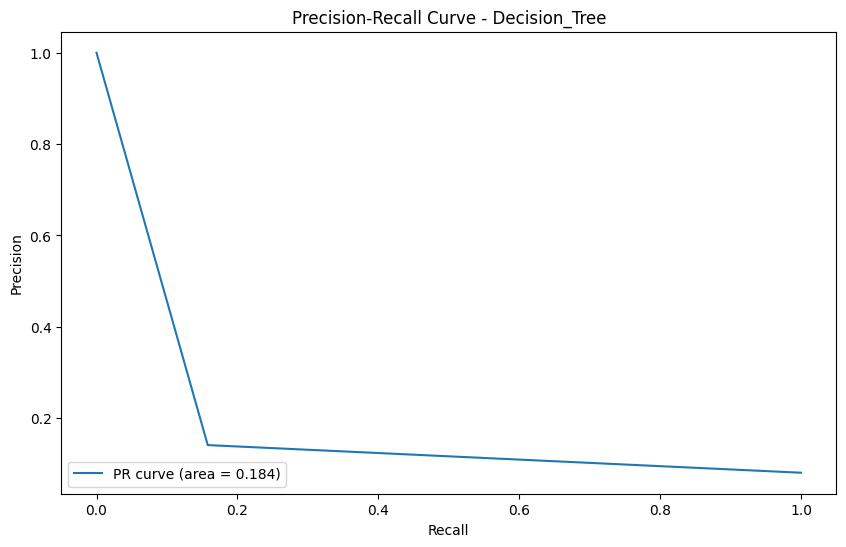

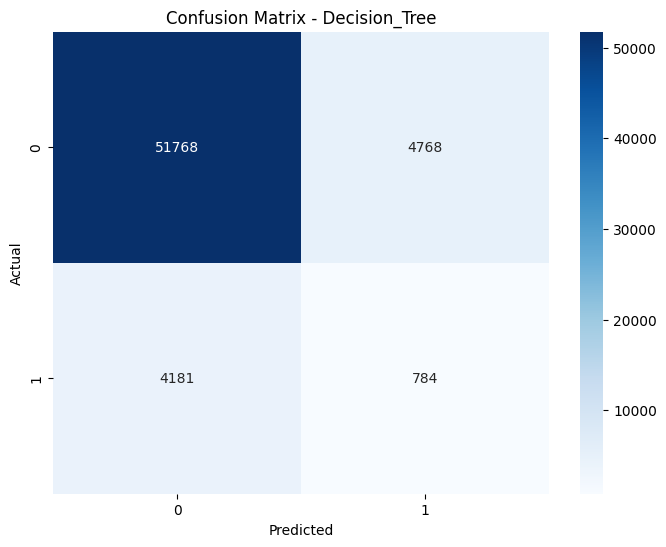

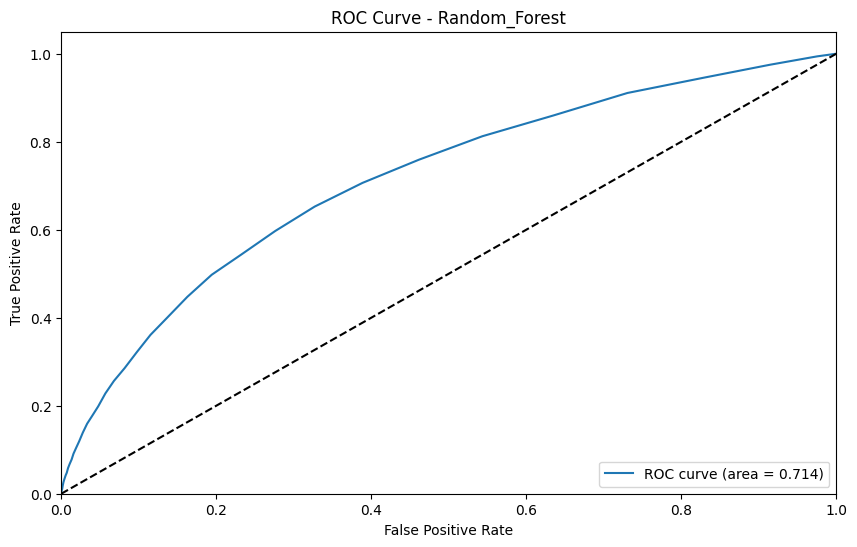

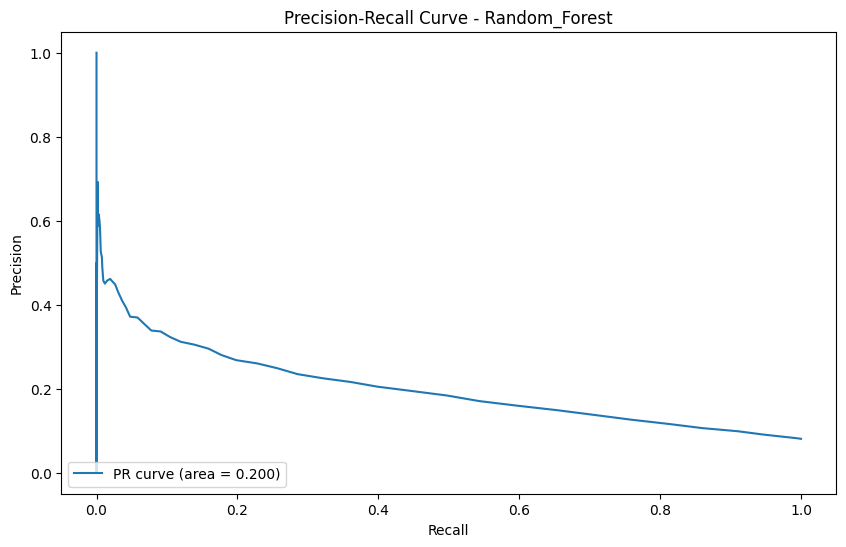

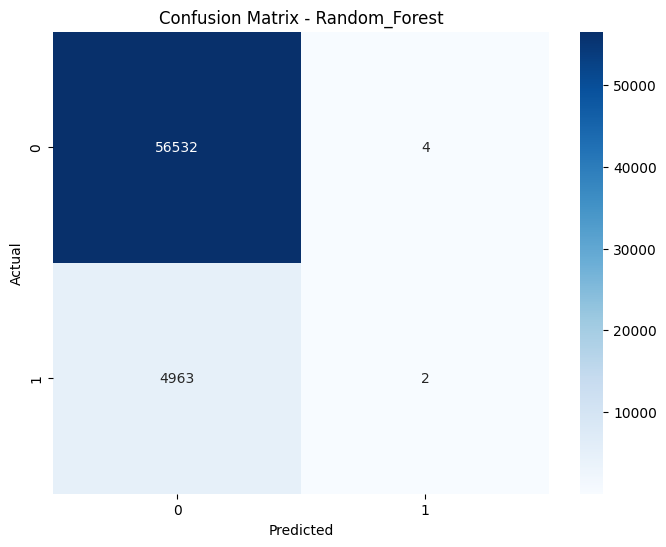

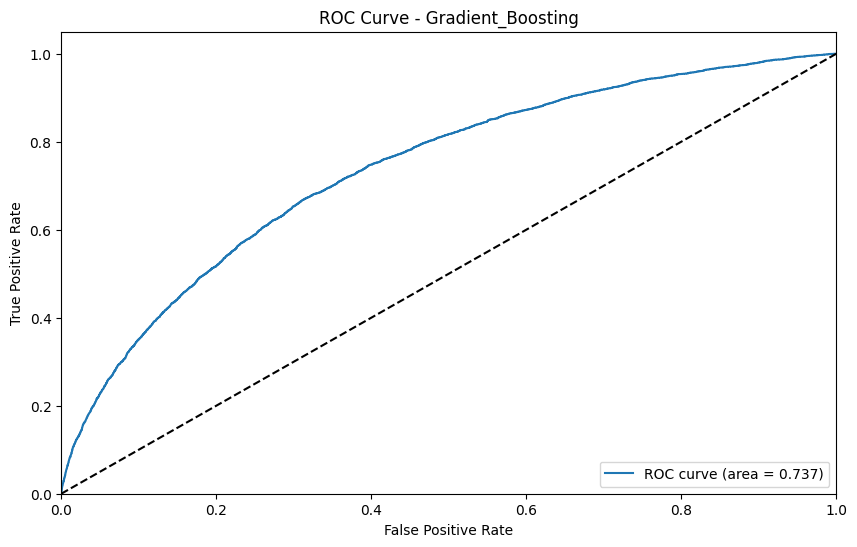

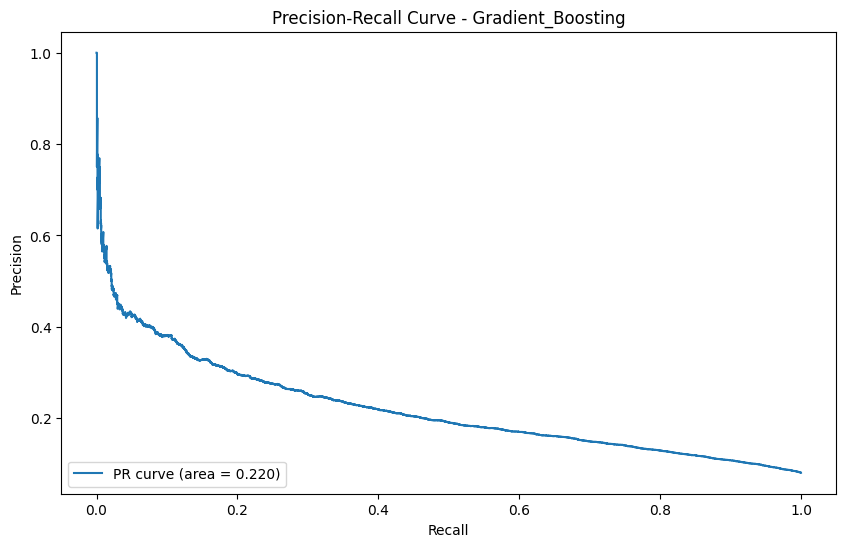

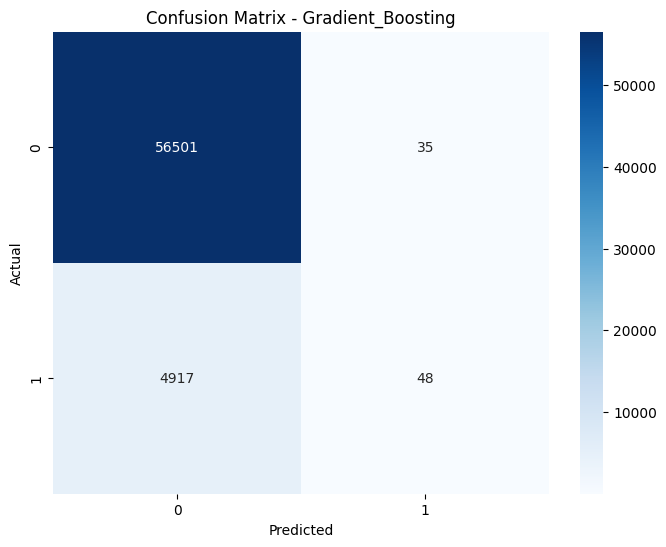

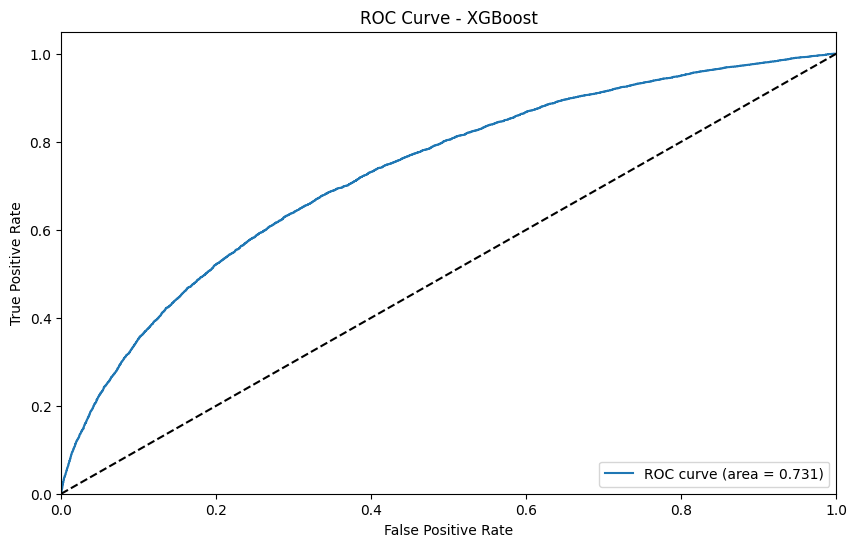

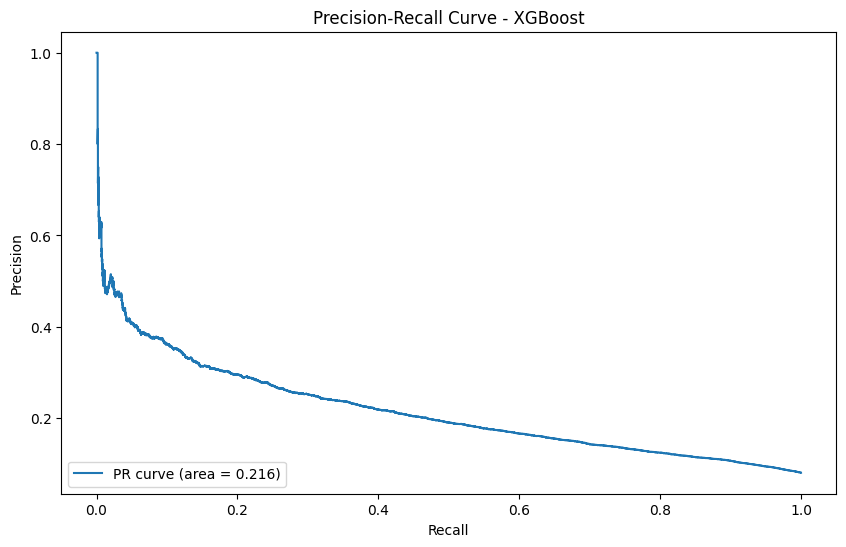

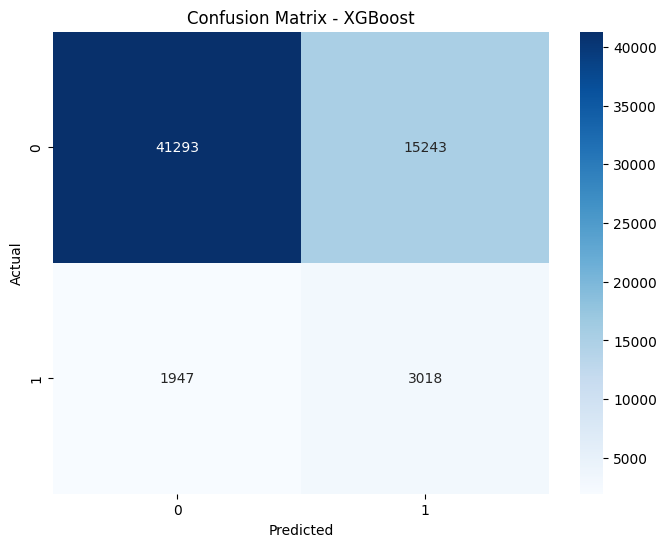

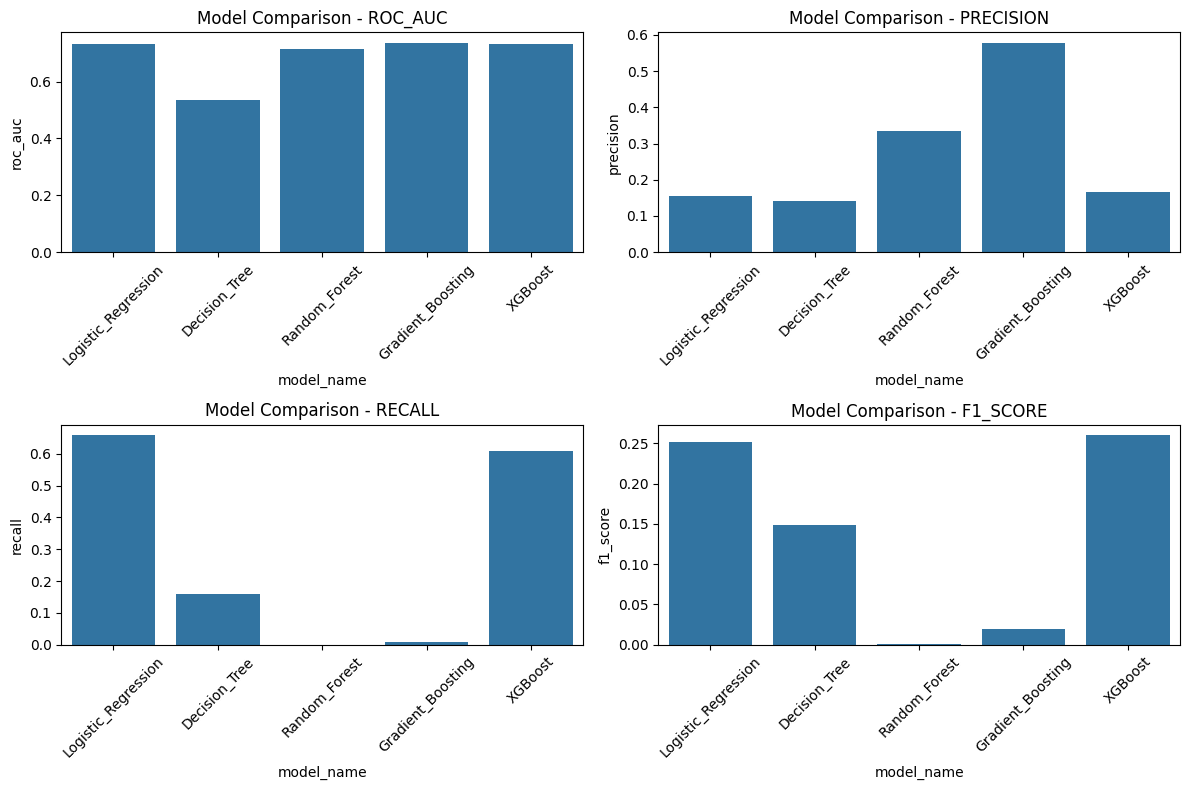

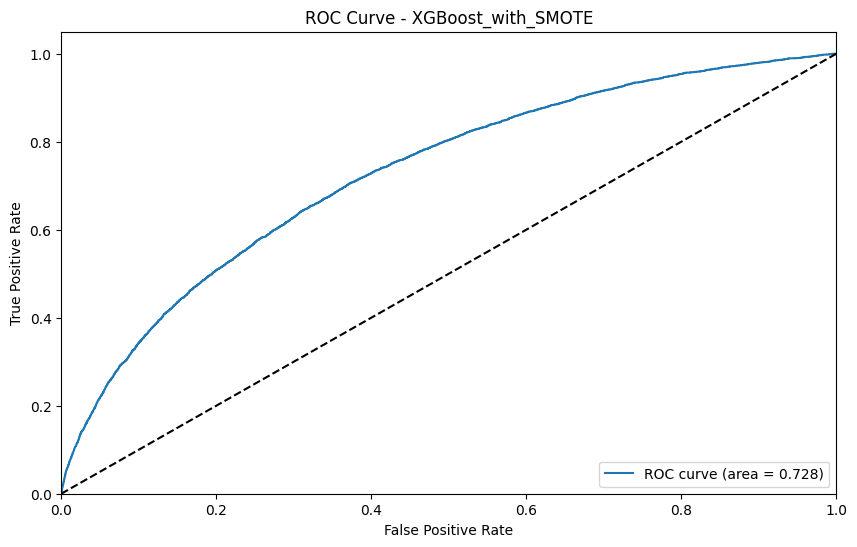

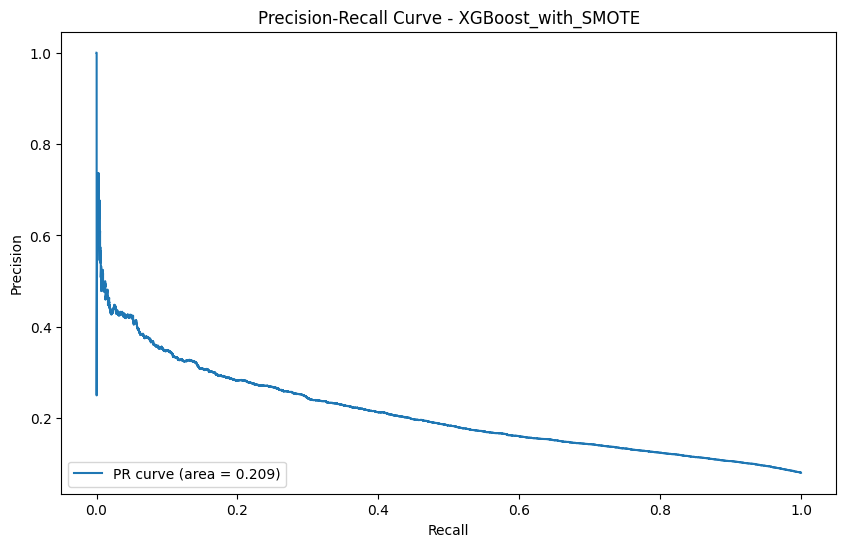

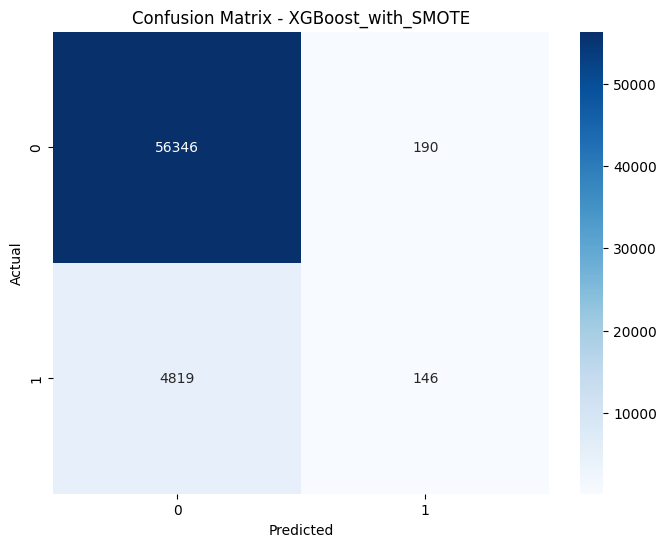

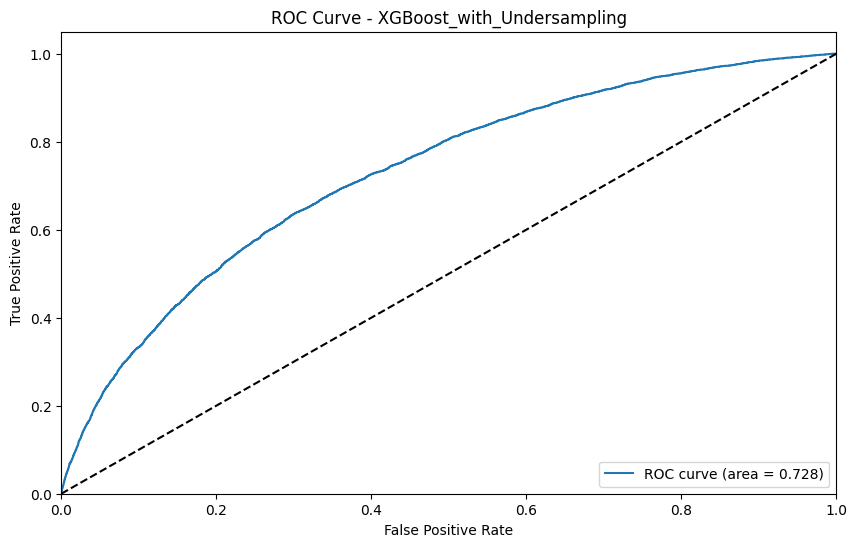

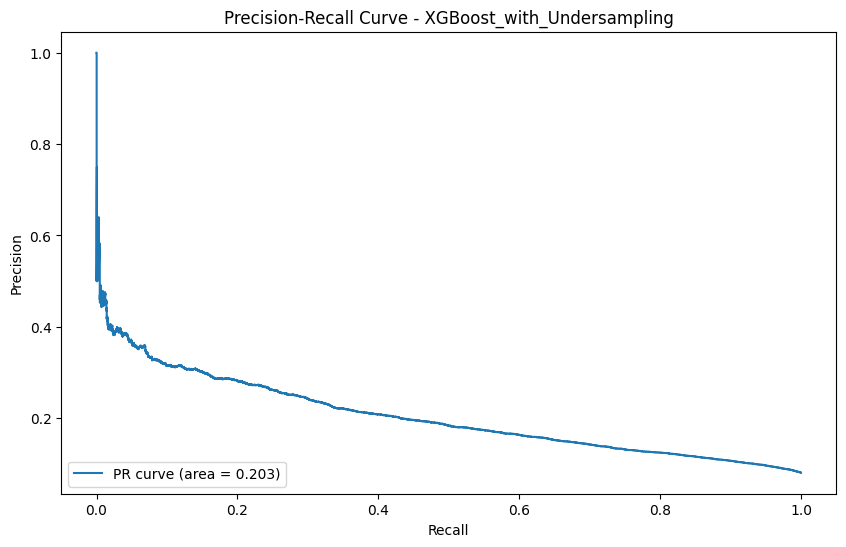

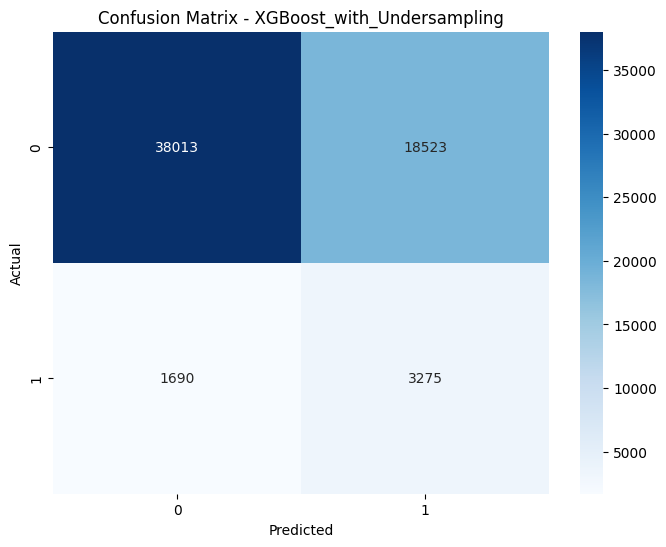

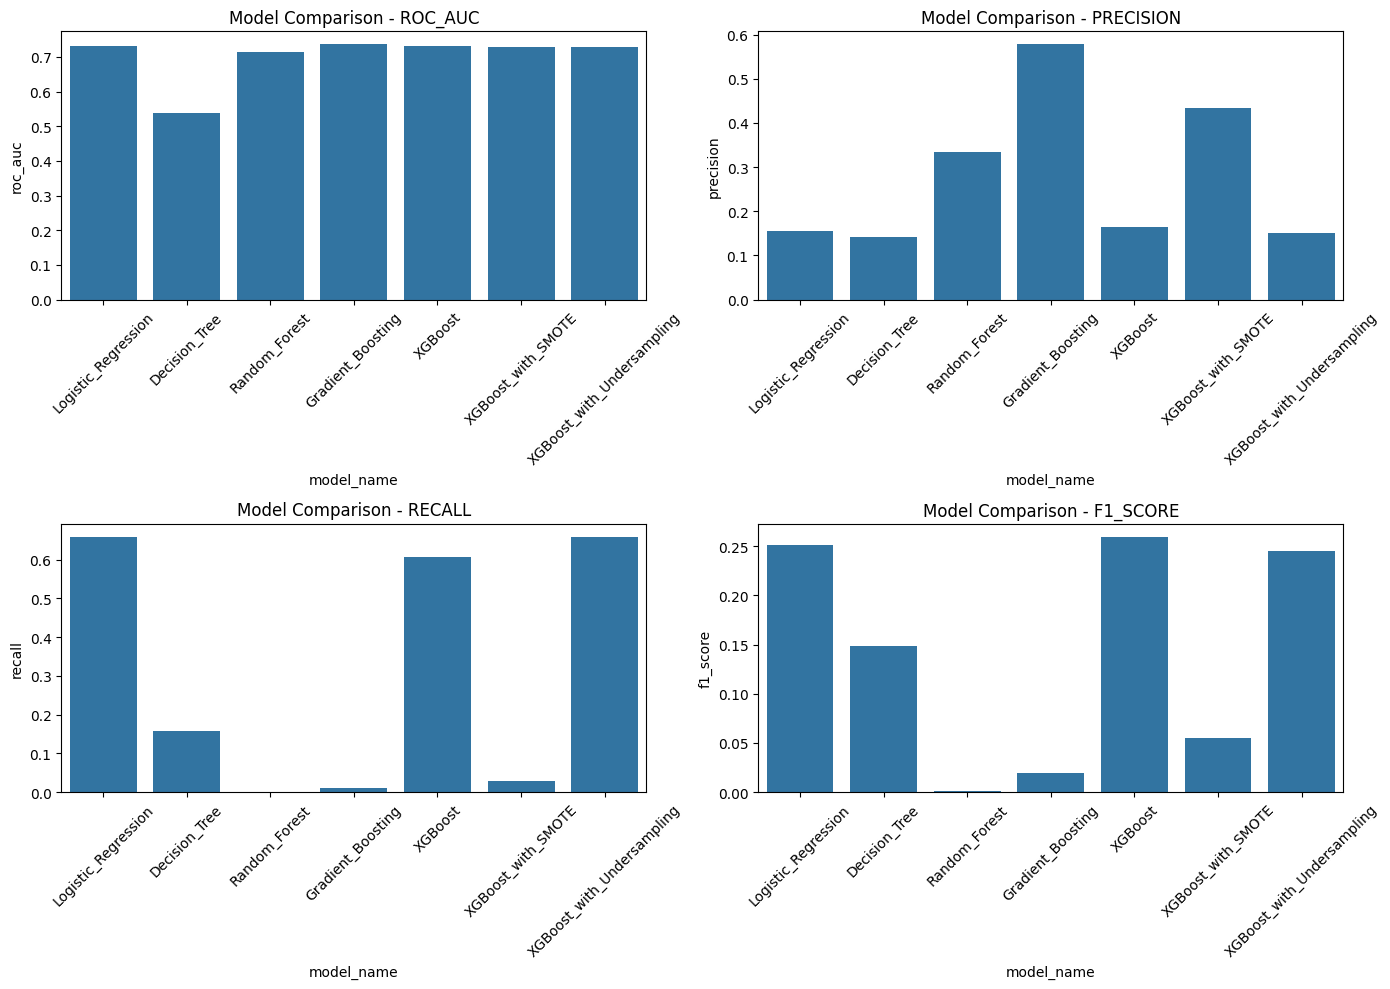

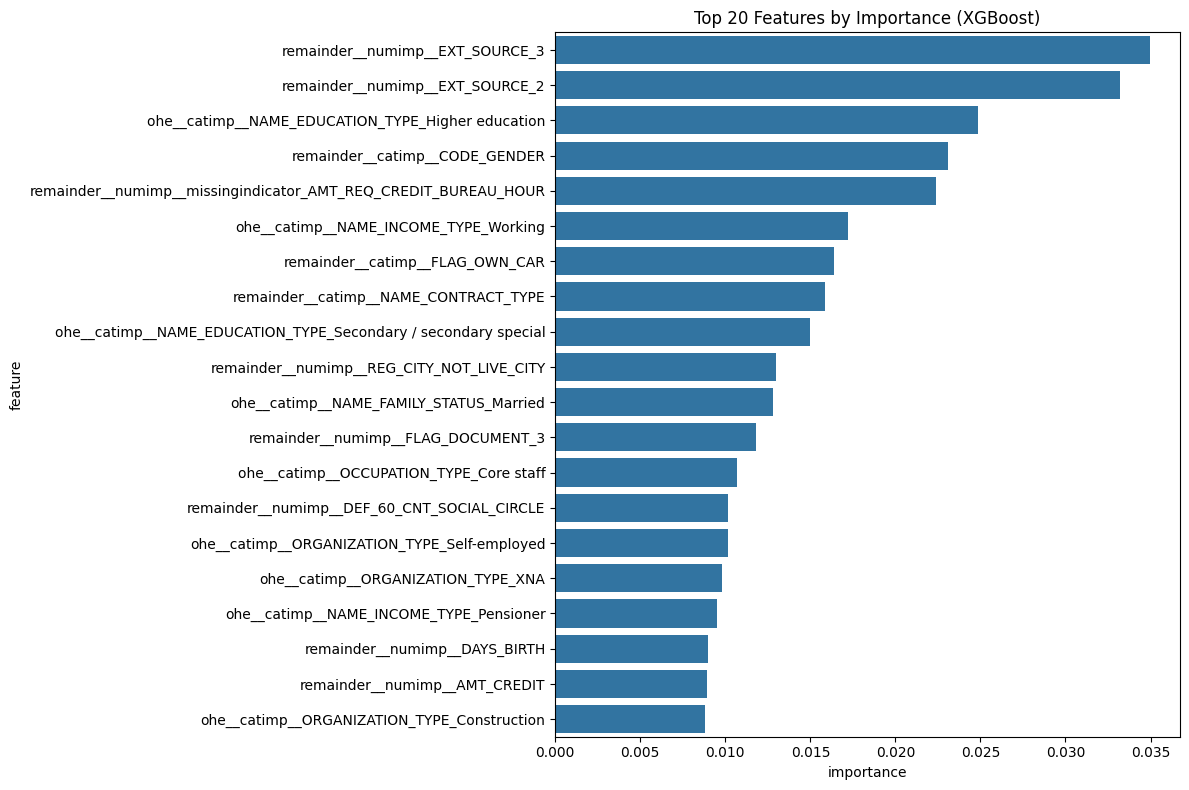

In [39]:
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, confusion_matrix
from sklearn.metrics import classification_report, roc_curve, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')
# Function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Create classification report
    report = classification_report(y_test, y_pred)
    
    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    # plt.savefig(f'ml_results/{model_name}_roc_curve.png')
    
    
    # Plot Precision-Recall curve
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall_curve, precision_curve)
    plt.figure(figsize=(10, 6))
    plt.plot(recall_curve, precision_curve, label=f'PR curve (area = {pr_auc:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend(loc="lower left")
    # plt.savefig(f'ml_results/{model_name}_pr_curve.png')
    
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    # plt.savefig(f'ml_results/{model_name}_confusion_matrix.png')
    
    
    # Return metrics
    return {
        'model_name': model_name,
        'roc_auc': roc_auc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'classification_report': report
    }

# Define models to evaluate
print("\nDefining models to evaluate...")
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(scale_pos_weight=11.39, random_state=42)  # Using the imbalance ratio
}

# Evaluate each model
print("\nEvaluating models...")
results = []
for name, model in models.items():
    print(f"Evaluating {name}...")
    result = evaluate_model(model, X_train, X_test, y_train, y_test, name.replace(' ', '_'))
    results.append(result)
    print(f"  ROC AUC: {result['roc_auc']:.4f}")
    print(f"  Precision: {result['precision']:.4f}")
    print(f"  Recall: {result['recall']:.4f}")
    print(f"  F1 Score: {result['f1_score']:.4f}")
    print(f"  Classification Report:\n{result['classification_report']}\n")

# Create results summary
results_df = pd.DataFrame(results)
results_df = results_df.drop('classification_report', axis=1)
# results_df.to_csv('ml_results/model_comparison.csv', index=False)

# Plot model comparison
plt.figure(figsize=(12, 8))
metrics = ['roc_auc', 'precision', 'recall', 'f1_score']
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    sns.barplot(x='model_name', y=metric, data=results_df)
    plt.title(f'Model Comparison - {metric.upper()}')
    plt.xticks(rotation=45)
    plt.tight_layout()
# plt.savefig('ml_results/model_comparison.png')


# Try SMOTE for handling class imbalance
print("\nEvaluating models with SMOTE for handling class imbalance...")
# Define SMOTE pipeline
smote_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(random_state=42))
])

# Evaluate SMOTE pipeline
smote_result = evaluate_model(smote_pipeline, X_train, X_test, y_train, y_test, 'XGBoost_with_SMOTE')
print(f"  ROC AUC: {smote_result['roc_auc']:.4f}")
print(f"  Precision: {smote_result['precision']:.4f}")
print(f"  Recall: {smote_result['recall']:.4f}")
print(f"  F1 Score: {smote_result['f1_score']:.4f}")
print(f"  Classification Report:\n{smote_result['classification_report']}\n")

# Try undersampling for handling class imbalance
print("\nEvaluating models with undersampling for handling class imbalance...")
# Define undersampling pipeline
under_pipeline = Pipeline([
    ('undersampler', RandomUnderSampler(random_state=42)),
    ('classifier', XGBClassifier(random_state=42))
])

# Evaluate undersampling pipeline
under_result = evaluate_model(under_pipeline, X_train, X_test, y_train, y_test, 'XGBoost_with_Undersampling')
print(f"  ROC AUC: {under_result['roc_auc']:.4f}")
print(f"  Precision: {under_result['precision']:.4f}")
print(f"  Recall: {under_result['recall']:.4f}")
print(f"  F1 Score: {under_result['f1_score']:.4f}")
print(f"  Classification Report:\n{under_result['classification_report']}\n")

# Add resampling results to comparison
results.append(smote_result)
results.append(under_result)
results_df = pd.DataFrame(results)
results_df = results_df.drop('classification_report', axis=1)
# results_df.to_csv('ml_results/model_comparison_with_resampling.csv', index=False)

# Plot final model comparison
plt.figure(figsize=(14, 10))
metrics = ['roc_auc', 'precision', 'recall', 'f1_score']
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    sns.barplot(x='model_name', y=metric, data=results_df)
    plt.title(f'Model Comparison - {metric.upper()}')
    plt.xticks(rotation=45)
    plt.tight_layout()
# plt.savefig('ml_results/final_model_comparison.png')


# Feature importance for the best model (assuming XGBoost performs well)
print("\nCalculating feature importance for XGBoost model...")
xgb_model = XGBClassifier(scale_pos_weight=11.39, random_state=42)
xgb_model.fit(X_train, y_train)

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)
# feature_importance.to_csv('ml_results/xgboost_feature_importance.csv', index=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(20)
sns.barplot(x='importance', y='feature', data=top_features)
plt.title('Top 20 Features by Importance (XGBoost)')
plt.tight_layout()
# plt.savefig('ml_results/xgboost_feature_importance.png')


print("\nMachine learning evaluation completed. Results saved to ml_results directory.")

# Summary of recommended approaches
print("\nRecommended Machine Learning Approaches for Loan Default Prediction:")
print("1. Gradient Boosting and XGBoost models typically perform well for this type of problem")
print("2. Class imbalance handling techniques like SMOTE or class weights are essential")
print("3. Feature selection based on importance can improve model performance")
print("4. Evaluation should focus on metrics like ROC AUC, Precision, Recall, and F1 Score")
print("5. Threshold tuning can help balance precision and recall based on business requirements")


In [40]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

In [41]:
model.fit(X_train, y_train)

LogisticRegression()